# TweetNiche: A tool for user niche exploration and analysis

#### Note
##### You are now on Google Colab, here you will be able to interact with each cell, run and tinker with the code, all on your browser.
**Note :**
* **You will be able to run the code only after signing into colab with your Google account.**
* **If the graphs do not show up or have loaded incorrectly, click `Runtime` in the tool bar and select `Run all`.**<br>
* **Since the notebook isn't authored by Google, a warning will show up citing the same.**<br>
* **Running the program is absolutely safe. Therefore, you can click `Run Anyway`.**


# Introduction

TweetNiche is a tool built for Twitter users & content creators looking to better understand the audience in their niche. Newbies to content creation often start out writing on a broad range of topics before finding a dedicated audience for a niche. Along the way, it is important to learn and understand various topics and explore several niche's before landing on one that works.

TweetNiche has two components: a recommender & a tweet analytics tool. 
Often, a user's Twitter feed is filled with content from a wide range of the user's interest and it can be hard to study a niche. TweetNiche recommends tweets which from user specified niche but also factoring in user's own tweets to maintain the relevance to the user.

The user may expect a tweet to perform well however reality may be different. TweetNiche's tweet analytics tool can help study a tweet's performance by showing a user's tweet in relation to other tweets in the Niche that are most similar but more popular than the user's tweet.



## Project Outline

### 1. Scope of the project:

* Recommend tweets specific to a niche that is relevant to the user
* Provide comparitive analysis for a user's tweet in the niche. 

### 2. Data:

Data will be scraped from twitter using snscrape API. The API allows extractions of tweets related to certain keywords and that posted by any user. The script can scrape 10,000 tweets in 20 minutes. 


### 3. Approach:

Part I
1. Extract user's tweets and tweets based on user specified topic from Twitter using snscrape library.
2. Processes both sets of tweets to remove stop words and tokenize the tweets using a BERT-based model.
3. From the user-topic set of tweets find tweets that are most similar to the user's tweets and recommend.

Part II
1. Allow user to select one of his tweet and its relevant niche. 
2. Extract and display top 10 most popular tweets in the niche that are also the most similar to the user's tweets.
3. Compare the popularity of user's tweets with the top tweets in niche.







# Importing & installing necessary libraries

In [ ]:
# installing necessary libraries
!pip install sweetviz
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.1 MB 13.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.2 MB 13.6 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 181 kB 62.0 MB/s 
     |████████████████████████████████| 10.1 MB 60.9 MB/s 
     |████████████████████████████████| 457 kB 75.5 MB/s 
     |████████████████████████████████| 660 kB 80.7 MB/s 
     |████████████████████████████████| 58 kB 7.5 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstal

In [ ]:
# importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz
from IPython.display import IFrame
from IPython.core.display import display, HTML
import numpy as np
import collections
import os

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
from datetime import datetime, timedelta
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import spatial
from wordcloud import WordCloud, STOPWORDS
from sentence_transformers import SentenceTransformer

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Getting the scraped data from gdrive

In [1]:
# getting data from gdrive 
!gdown --fuzzy https://drive.google.com/file/d/1-3QP1Q54RqNhg5GLvJxrZSV20QaN27LL/view?usp=sharing
!gdown --fuzzy https://drive.google.com/file/d/15Hk1q0baHtPr86TonUmlggWm0grjrqQ_/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1-3QP1Q54RqNhg5GLvJxrZSV20QaN27LL
To: /content/tweets.csv
100% 5.44M/5.44M [00:00<00:00, 70.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=15Hk1q0baHtPr86TonUmlggWm0grjrqQ_
To: /content/user_data_twitter.csv
100% 454k/454k [00:00<00:00, 26.8MB/s]


In [ ]:
# loading user & tweet data
tweets_df = pd.read_csv('/content/tweets.csv') 
user_df = pd.read_csv('/content/user_data_twitter.csv')

In [ ]:
# some pre processing
tweets_df = tweets_df.reset_index(drop=True) 
tweets_df = tweets_df.rename(columns={'content': 'tweet_content'}) 
tweets_df.head(1) 

url  \
0  https://twitter.com/BrainArtLabs/status/153494...   

                  tweet_date  \
0  2022-06-09 17:07:57+00:00   

                                       tweet_content             tweet_id  \
0  "A golden prismic room on a rainy day under st...  1534945407855476736   

   reply_count  retweet_count  like_count  quote_count      conversation_id  \
0            0              0           0            0  1534945407855476736   

  language  ...              user_id      username    displayname  \
0       en  ...  1423308870882111488  BrainArtLabs  BrainArt Labs   

                                         description followers_count  \
0  🔬Experimentation, Research, Studies, Experimen...             139   

  friends_count statuses_count  favourites_count  listed_count  media_count  
0           261            317               727             3          159  

[1 rows x 23 columns]

# Understanding the Data & Visualisations
## Tweets Data scraped by sns scrape - the code for scraping is in the backend folder of gdrive

In [ ]:
# Reading the data 
df = pd.read_csv('/content/tweets.csv')
df.head() 

url  \
0  https://twitter.com/BrainArtLabs/status/153494...   
1  https://twitter.com/hashem25/status/1534945236...   
2  https://twitter.com/milocamj/status/1534945188...   
3  https://twitter.com/kalpak_savaliya/status/153...   
4  https://twitter.com/KYTechnado/status/15349450...   

                  tweet_date  \
0  2022-06-09 17:07:57+00:00   
1  2022-06-09 17:07:16+00:00   
2  2022-06-09 17:07:05+00:00   
3  2022-06-09 17:07:02+00:00   
4  2022-06-09 17:06:32+00:00   

                                             content             tweet_id  \
0  "A golden prismic room on a rainy day under st...  1534945407855476736   
1  NLP on Amazon Reviews #ArtificialIntelligence ...  1534945236547420161   
2  Ministry of Education, AICTE and AWS to Upskil...  1534945188010831875   
3  Gadget Game News : Google Chrome’s on-device m...  1534945174018838530   
4  Google says it used machine learning to massiv...  1534945048307159041   

   reply_count  retweet_count  like_count  quote_count      conversation_id  \
0            0              0           0            0  1534945407855476736   
1            0              0           0            0  1534945236547420161   
2            0              1           0            0  1534945188010831875   
3            0              0           0            0  1534945174018838530   
4            0              0           0            0  1534945048307159041   

  language  ...              user_id         username      displayname  \
0       en  ...  1423308870882111488     BrainArtLabs    BrainArt Labs   
1       en  ...             49287937         hashem25  Hashem AbuBaker   
2       en  ...             28119151         milocamj     Milo Camacho   
3       en  ...  1441996327559127049  kalpak_savaliya  kalpak savaliya   
4       en  ...  1067899048609398785       KYTechnado      KY Technado   

                                         description followers_count  \
0  🔬Experimentation, Research, Studies, Experimen...             139   
1             ehealth, Green Tech, IoT, AI, Startups            2358   
2  Never stop #learning and #adapting, the day yo...            2704   
3                                  I am web marketer              83   
4  Technado show from Lexington KY\nJames Mason a...             417   

  friends_count statuses_count  favourites_count  listed_count  media_count  
0           261            317               727             3          159  
1          2025          38791              2790            95          119  
2            49         163780              3944          1256       108637  
3             3          70175                 0             2            0  
4           833          40399               823             0          404  

[5 rows x 23 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   url                  10000 non-null  object
 1   tweet_date           10000 non-null  object
 2   content              10000 non-null  object
 3   tweet_id             10000 non-null  int64 
 4   reply_count          10000 non-null  int64 
 5   retweet_count        10000 non-null  int64 
 6   like_count           10000 non-null  int64 
 7   quote_count          10000 non-null  int64 
 8   conversation_id      10000 non-null  int64 
 9   language             10000 non-null  object
 10  retweeted_tweet_id   10000 non-null  object
 11  quoted_tweet_id      10000 non-null  object
 12  inreply_to_tweet_id  10000 non-null  object
 13  user_id              10000 non-null  int64 
 14  username             10000 non-null  object
 15  displayname          10000 non-null  object
 16  descr

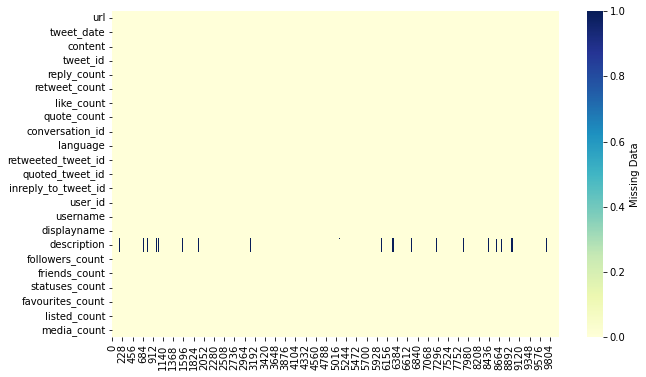

In [ ]:
# Visualising nan values using seaborn heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=500)

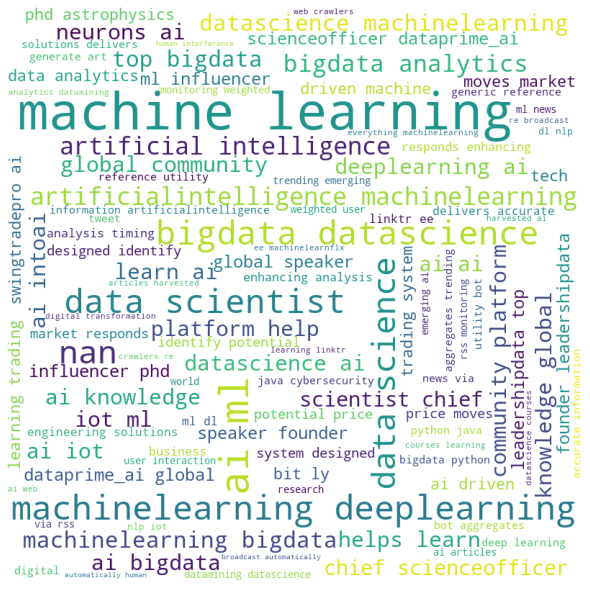

<Figure size 432x288 with 0 Axes>

In [ ]:
# Visualising the words in the Tweets users description
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df.description:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()
plt.savefig("visualizing_words_in_tweet_users_description.png", dpi=500)

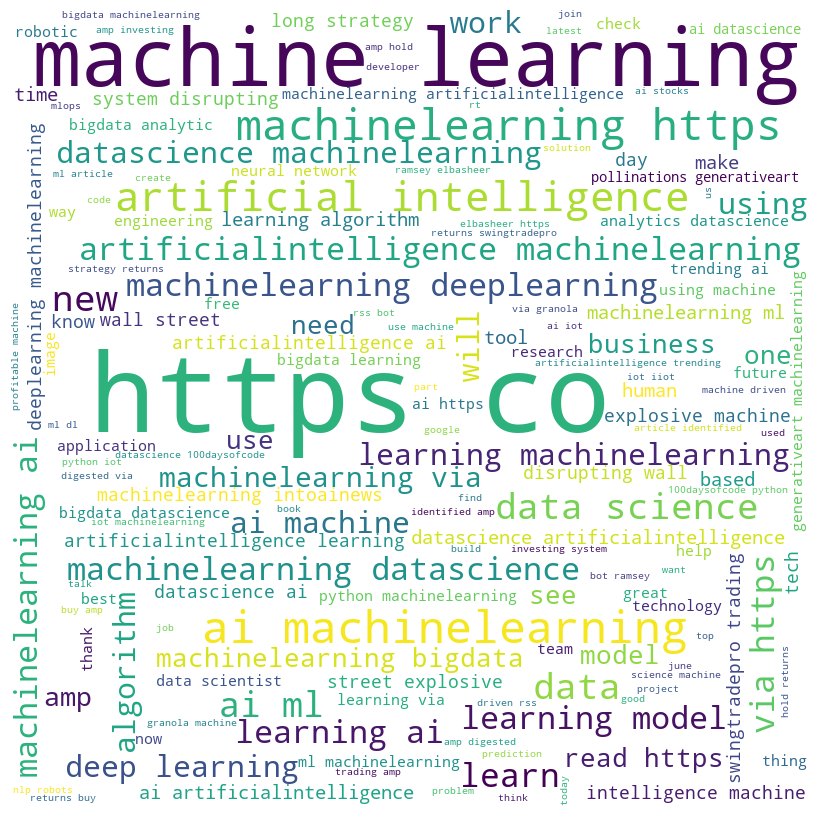

<Figure size 600x400 with 0 Axes>

In [ ]:
# Visualising the words in the Tweets content
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df.content:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()
plt.savefig("visualizing_words_in_tweet_content.png", dpi=500)

In [ ]:
# Generating Sweetviz report
my_report = sweetviz.analyze([df, "Train"],target_feat='like_count')
my_report.show_html('Report.html') 

                                             |          | [  0%]   00:00 -> (? left)

Report Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



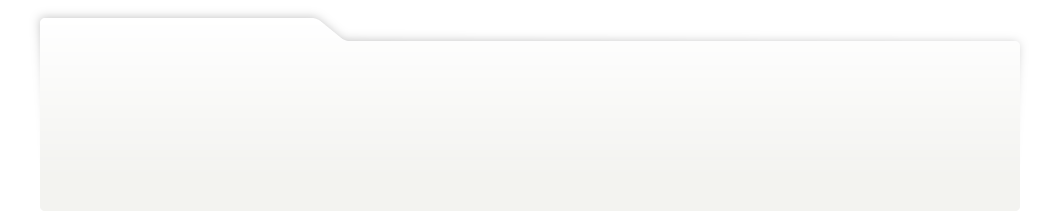
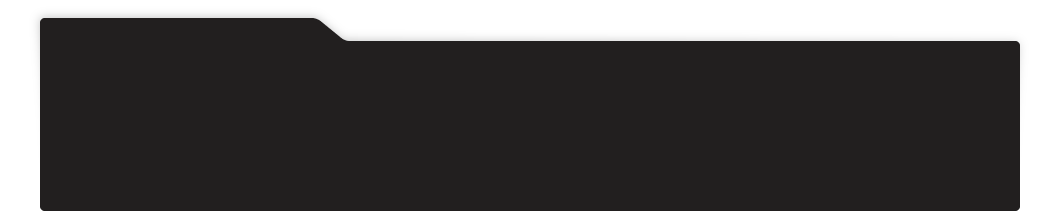
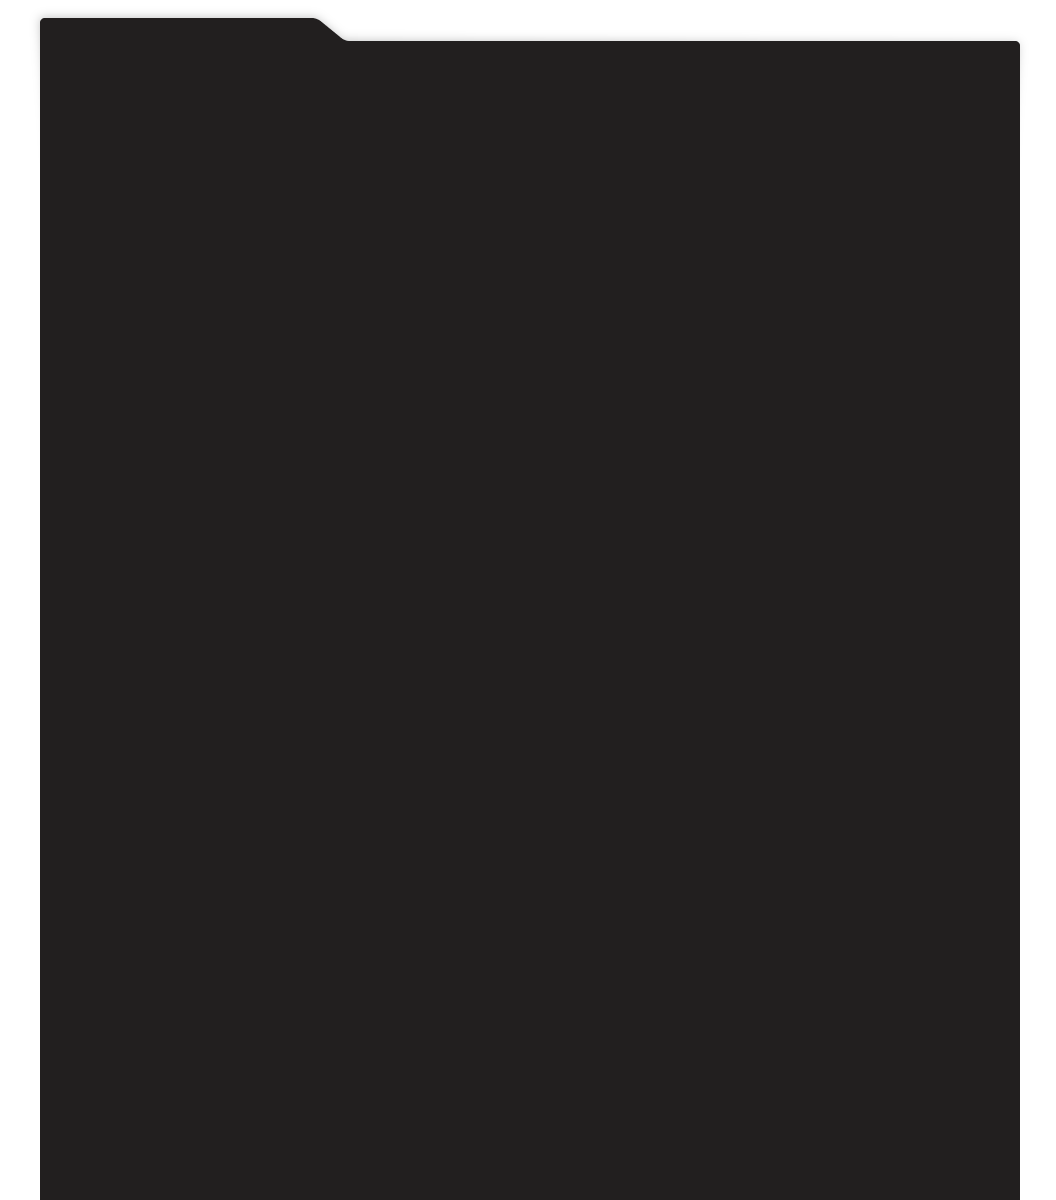
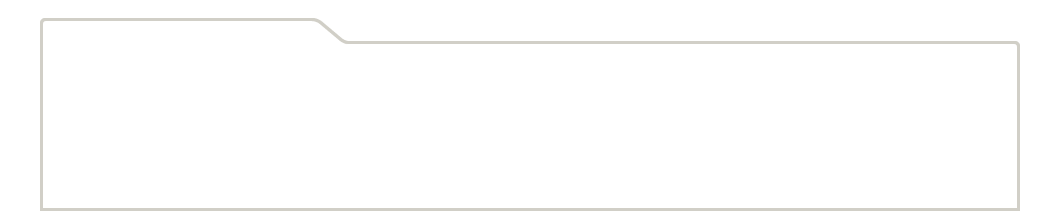
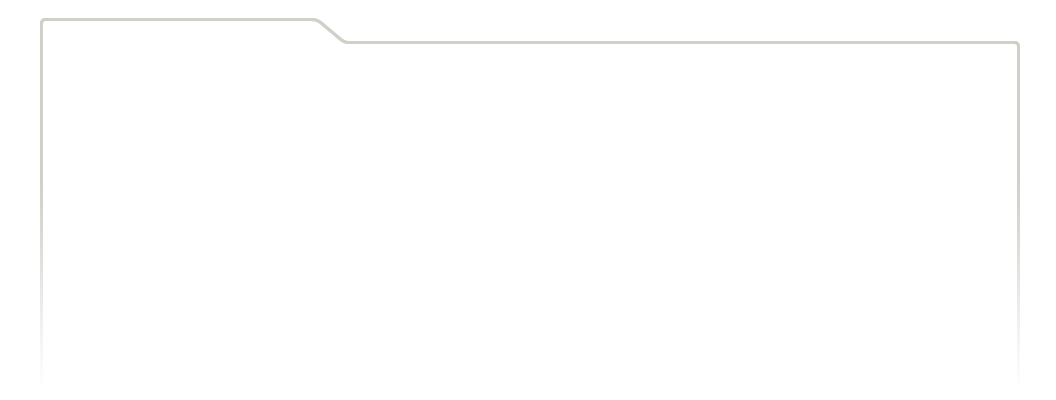
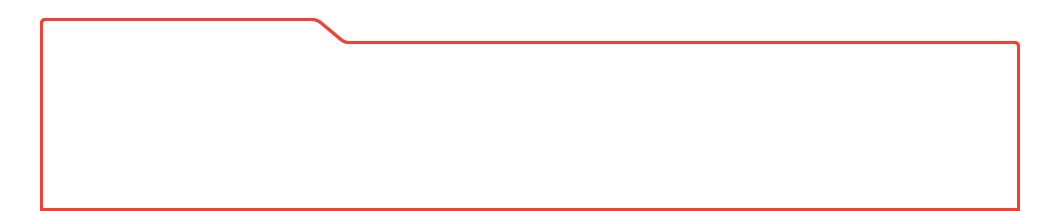
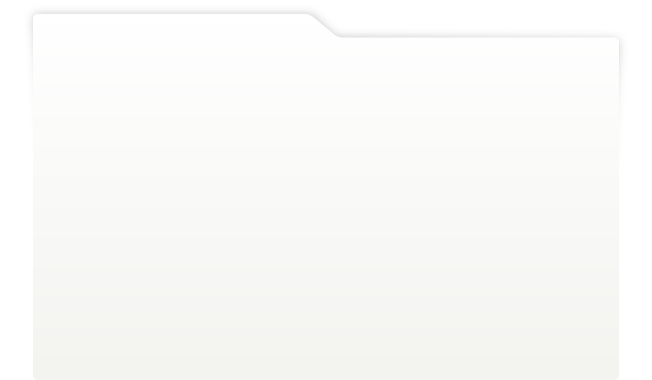
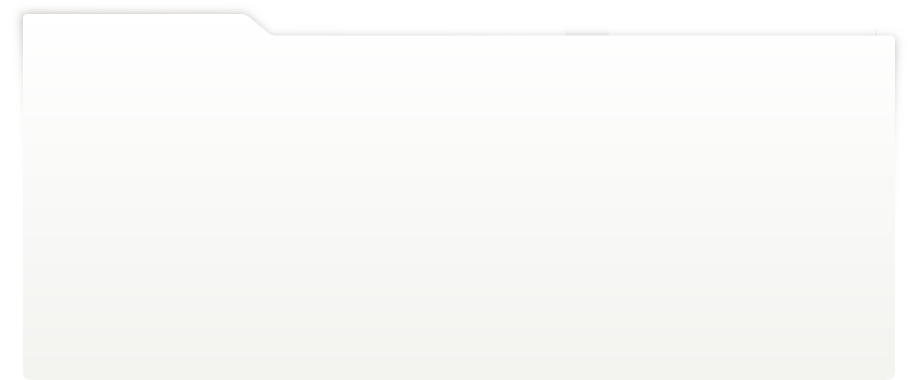
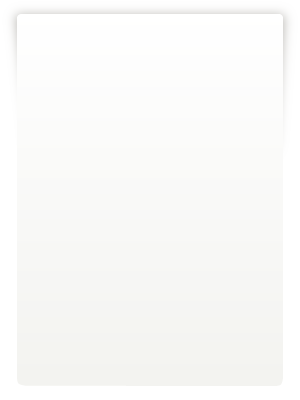
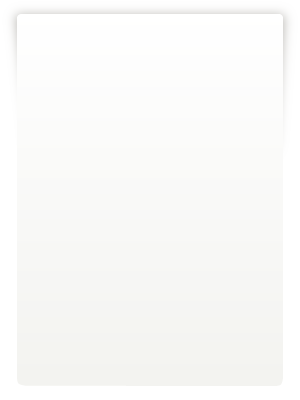
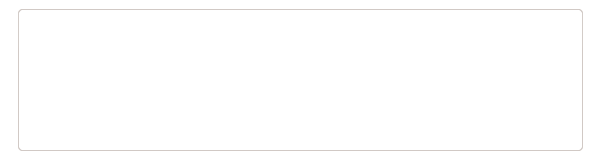
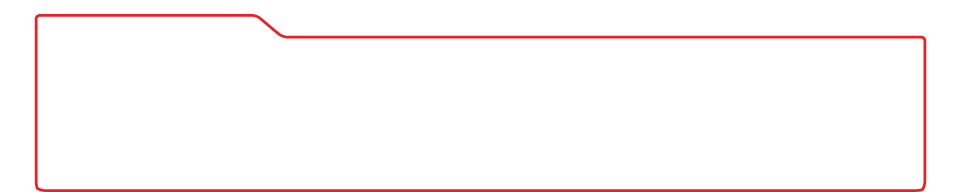
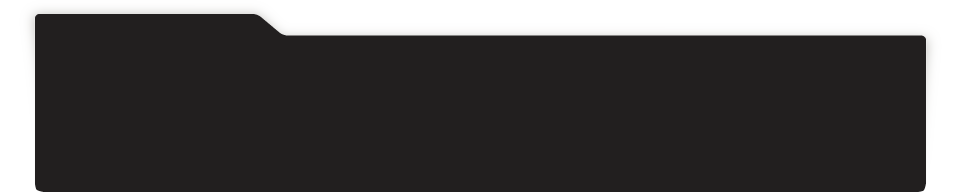
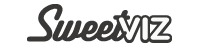
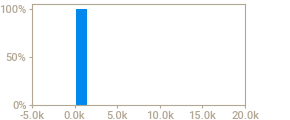
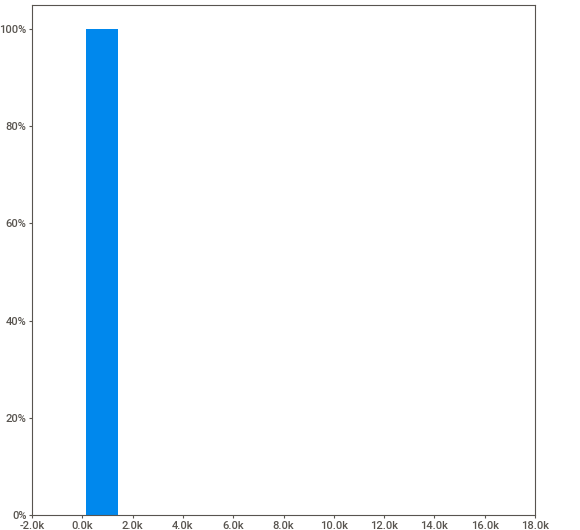
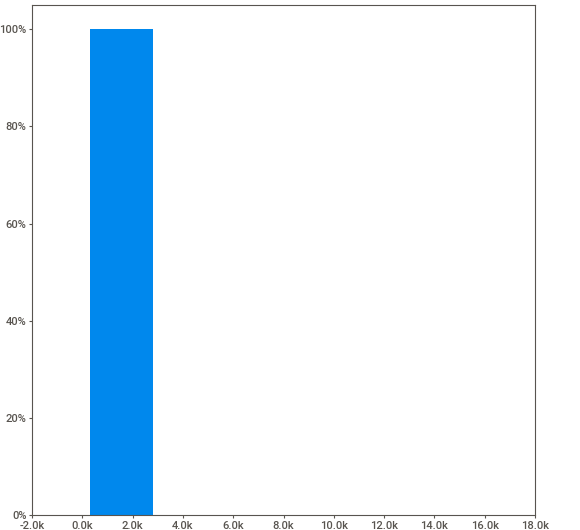
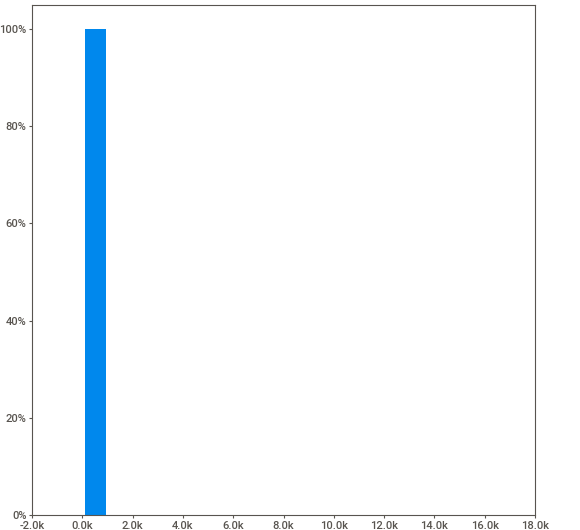
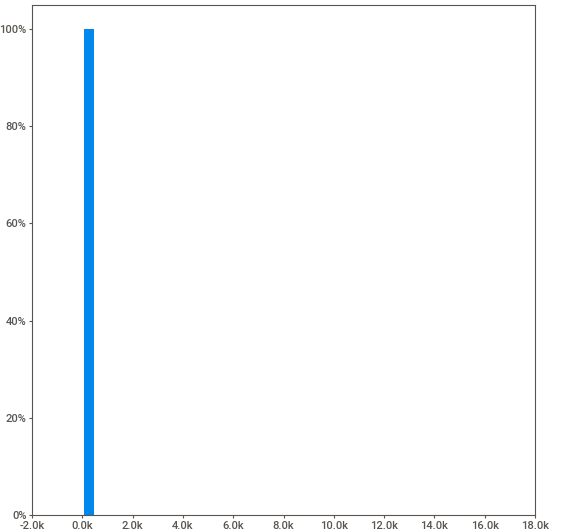
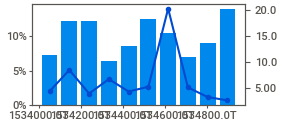
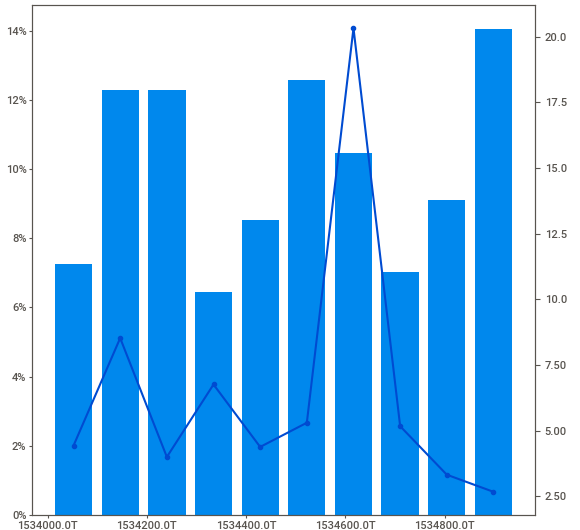
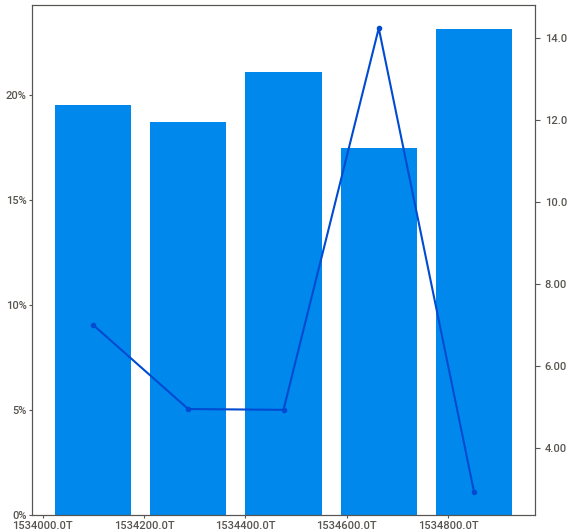
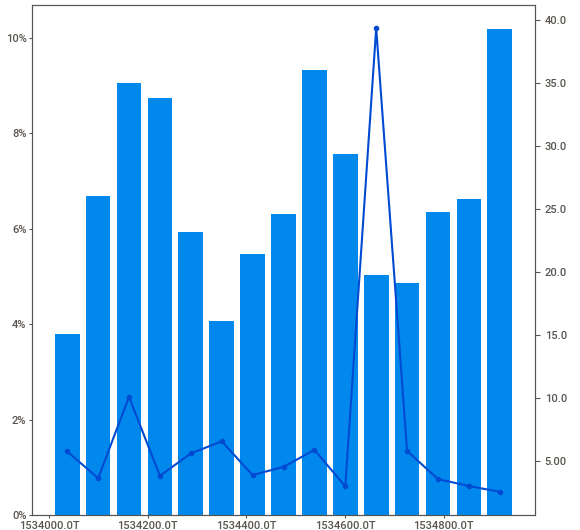
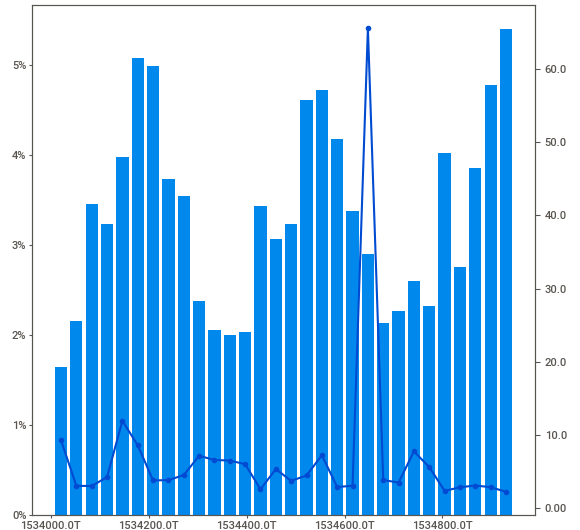
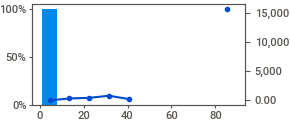
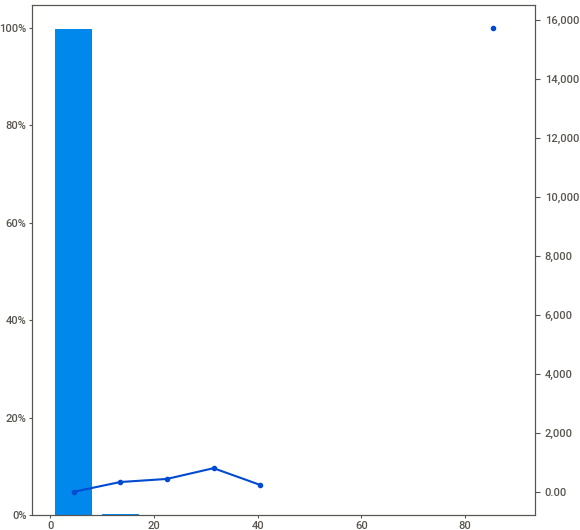
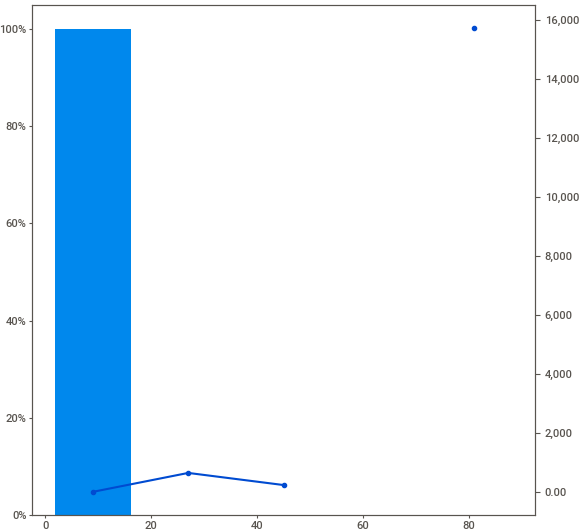
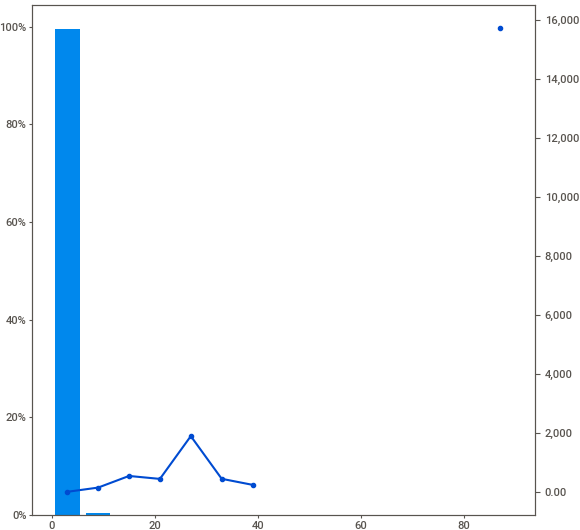
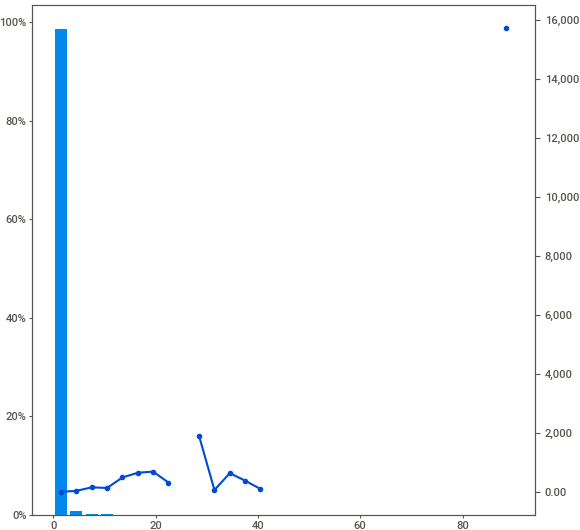
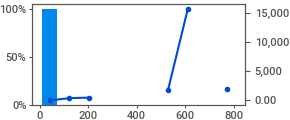
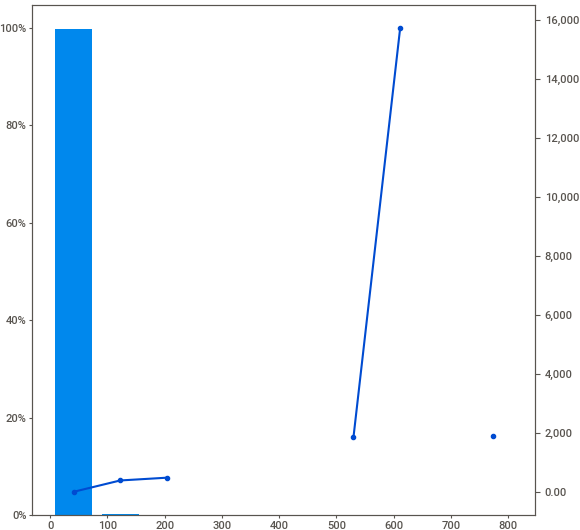
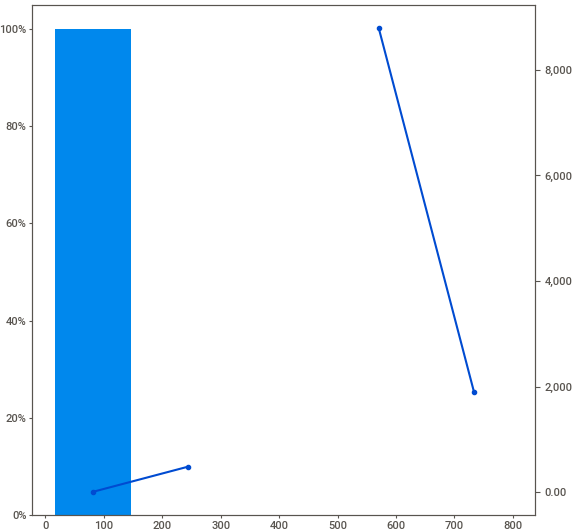
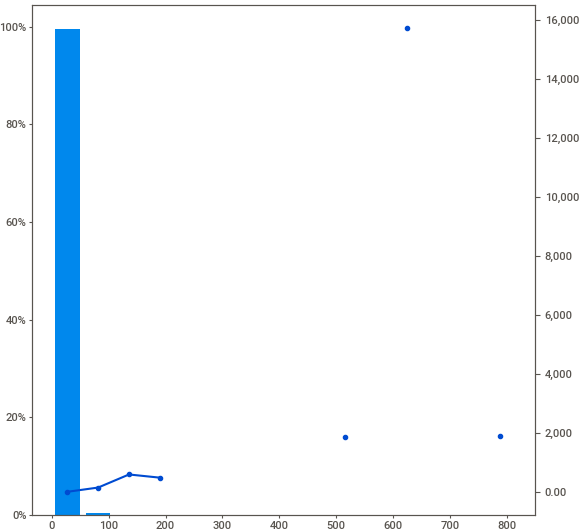
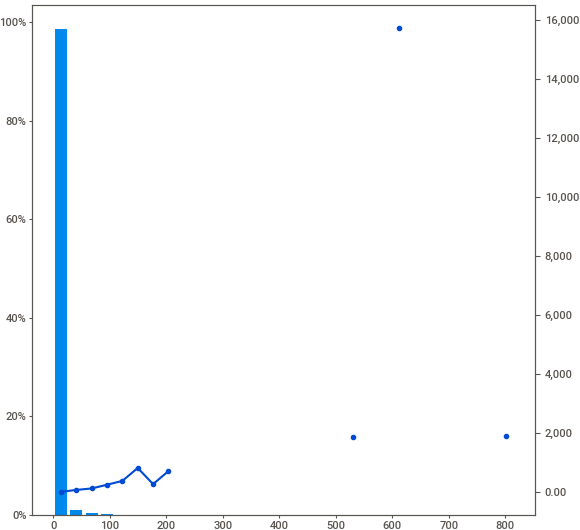
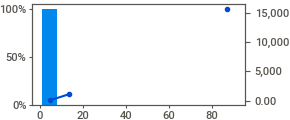
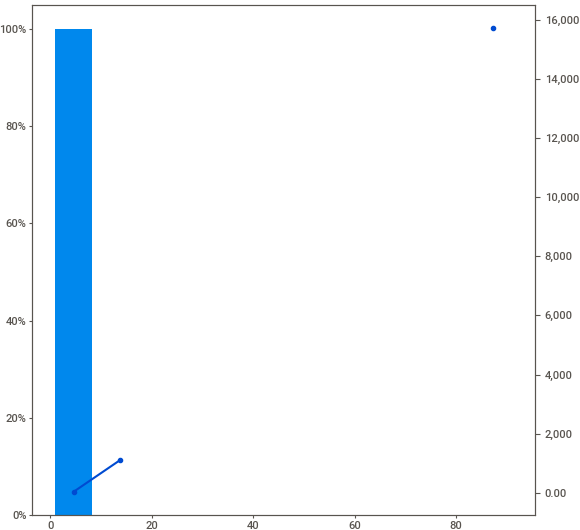
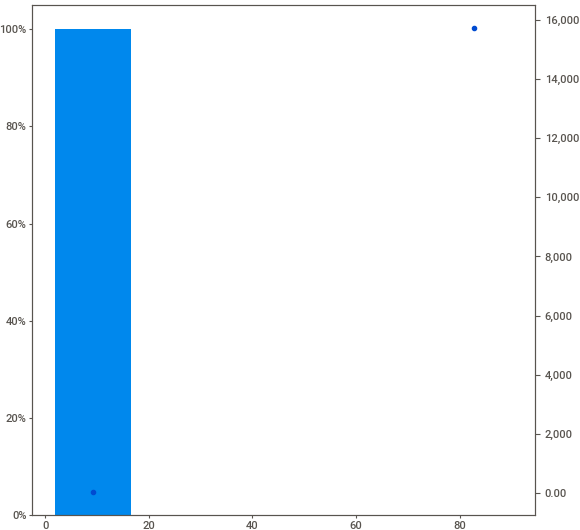
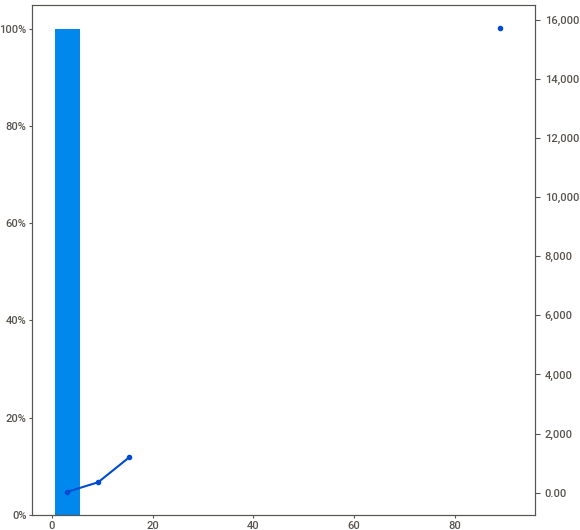
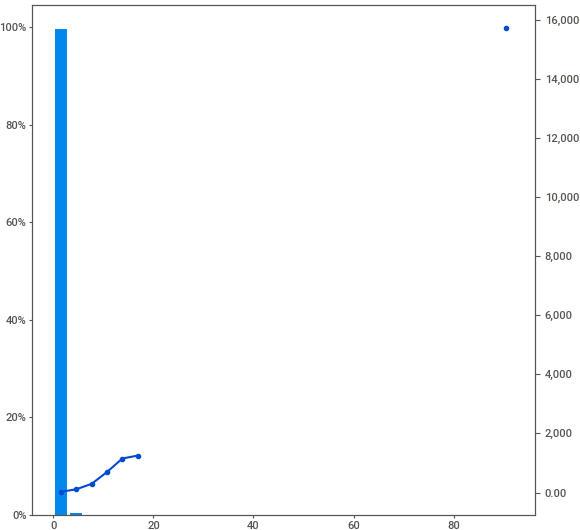
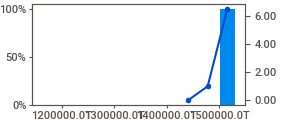
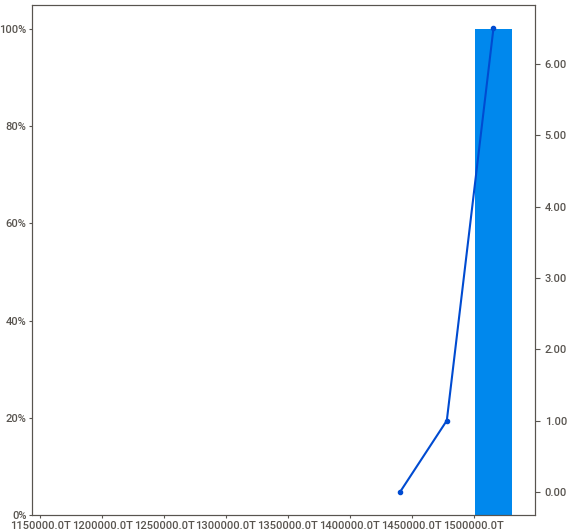
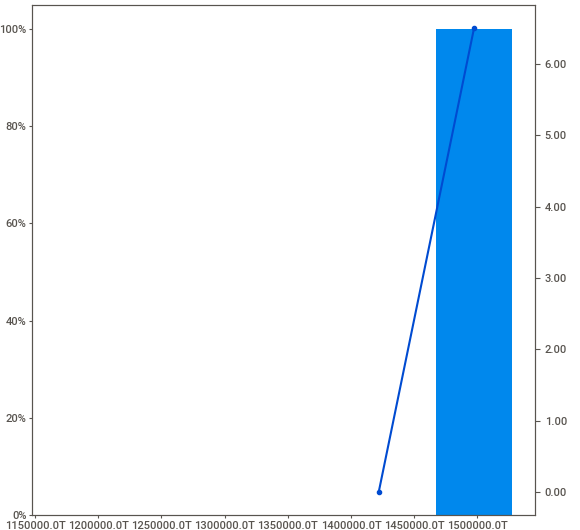
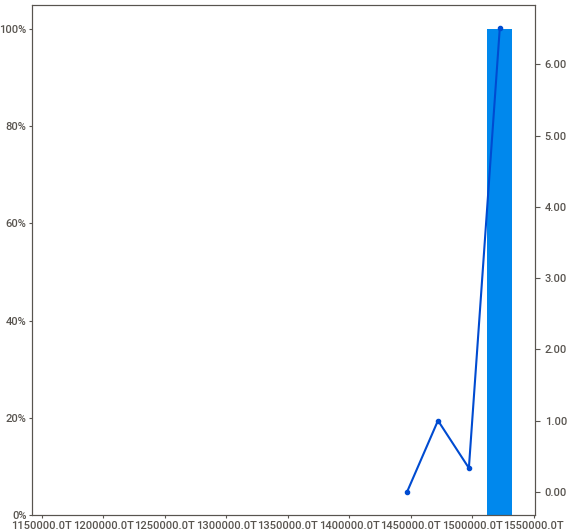
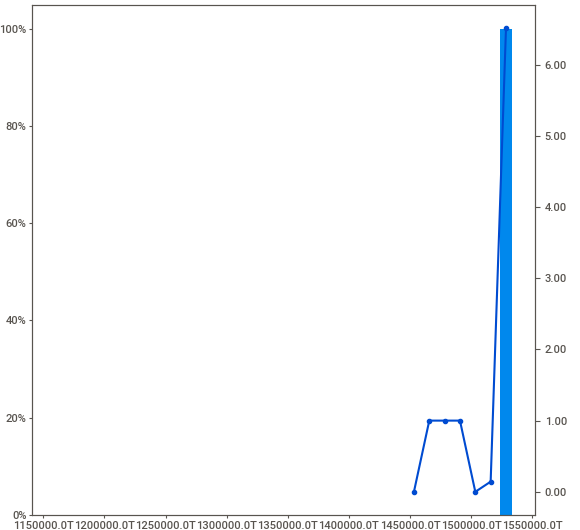
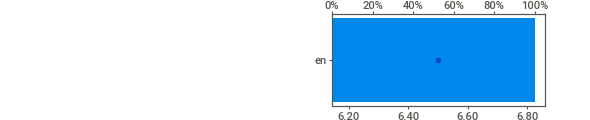
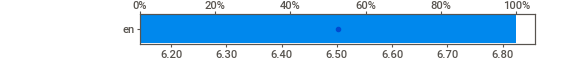
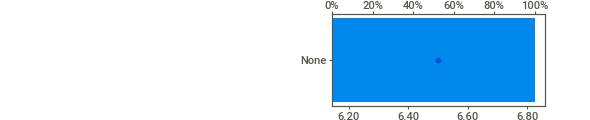
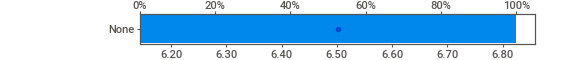
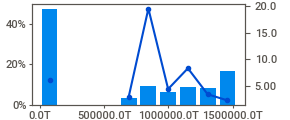
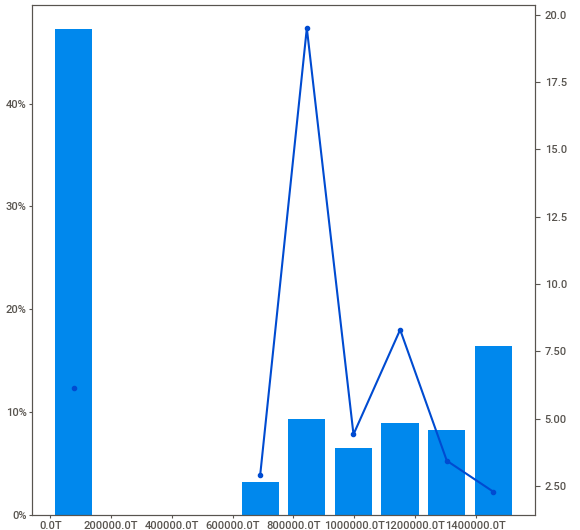
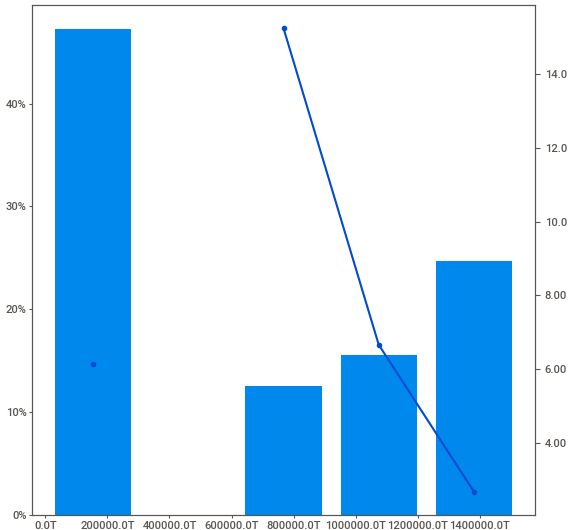
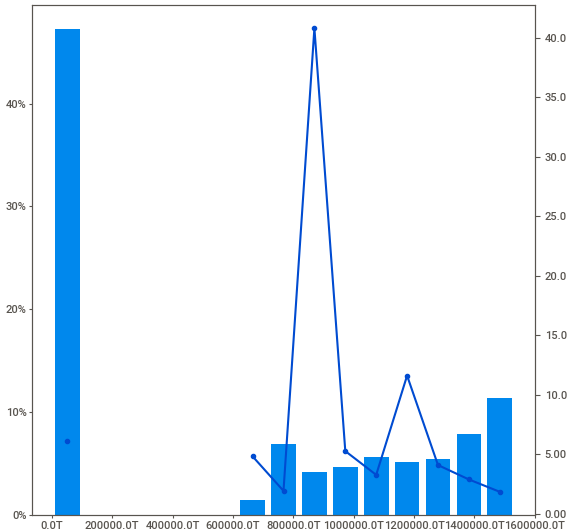
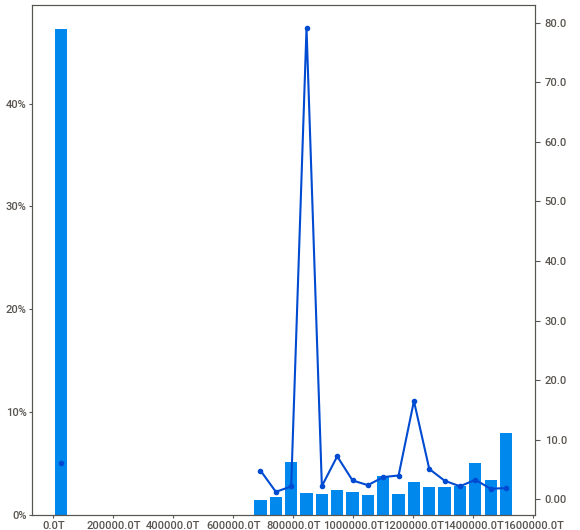
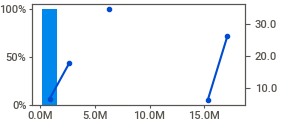
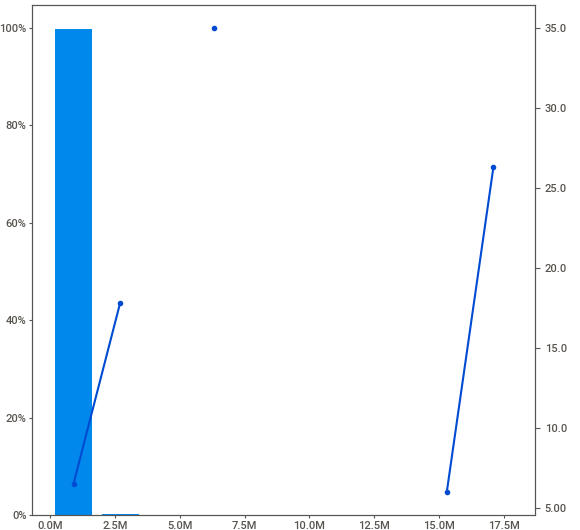
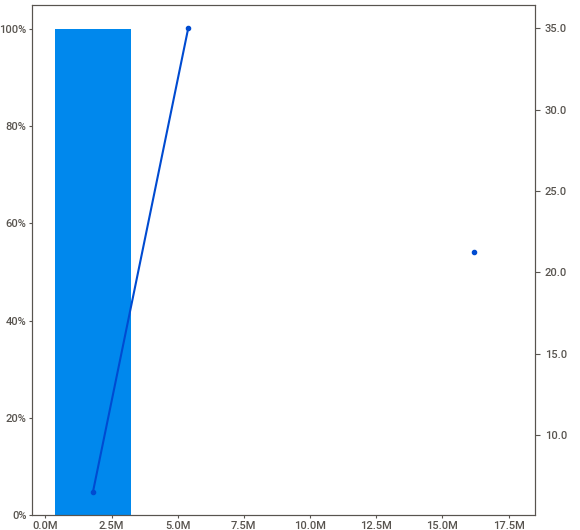
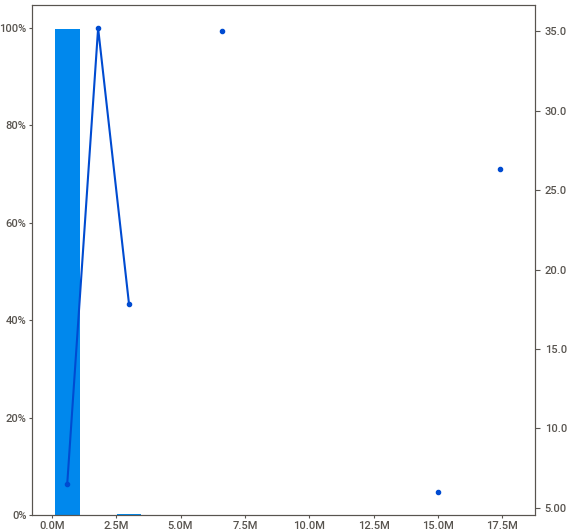
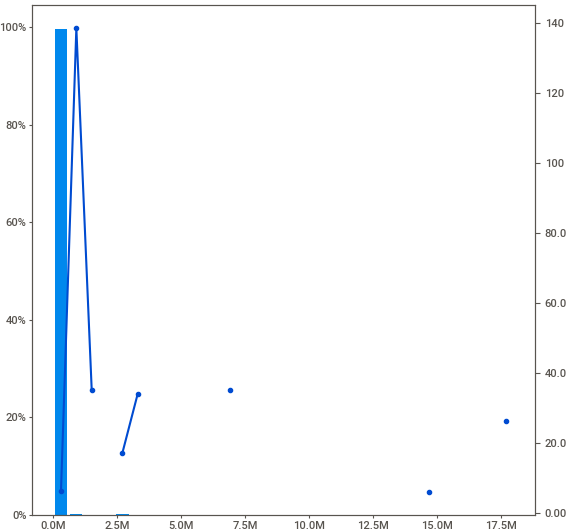
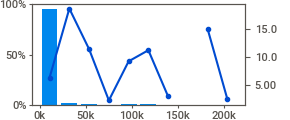
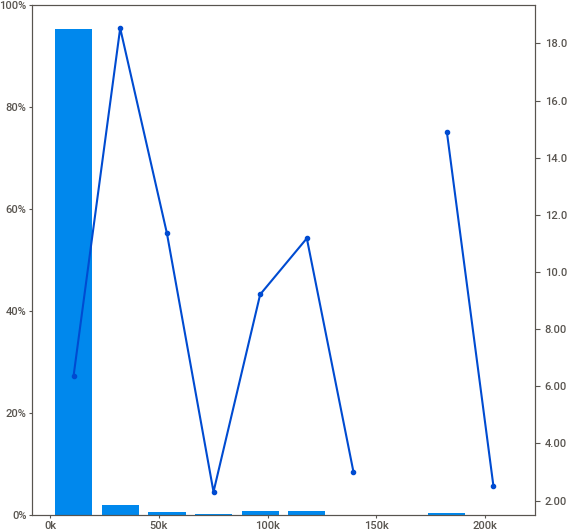
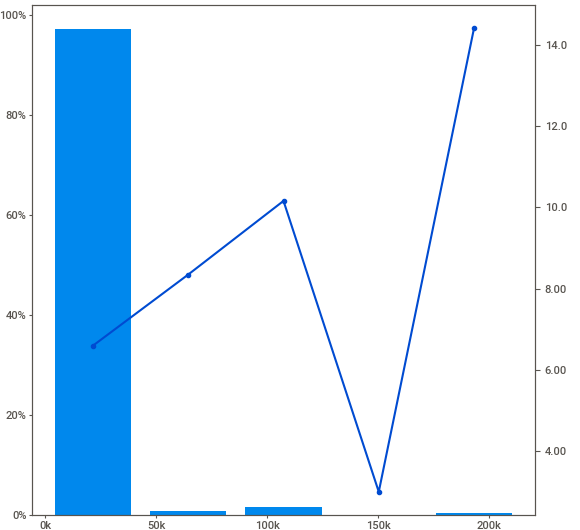
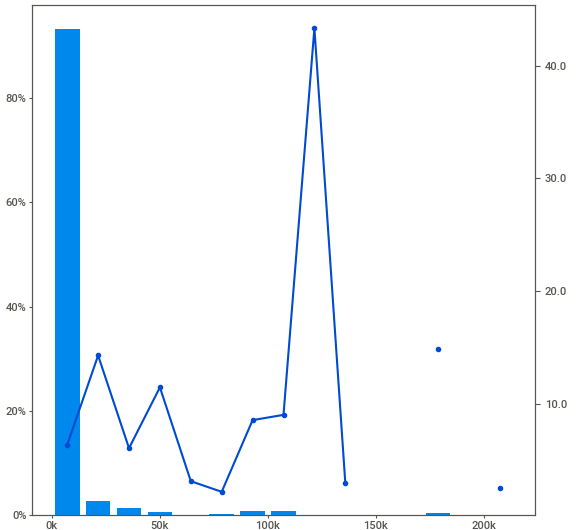
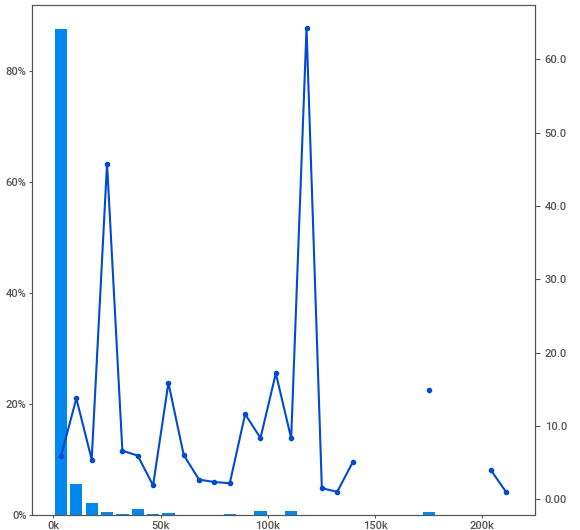
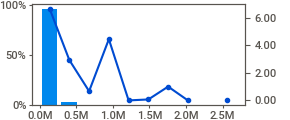
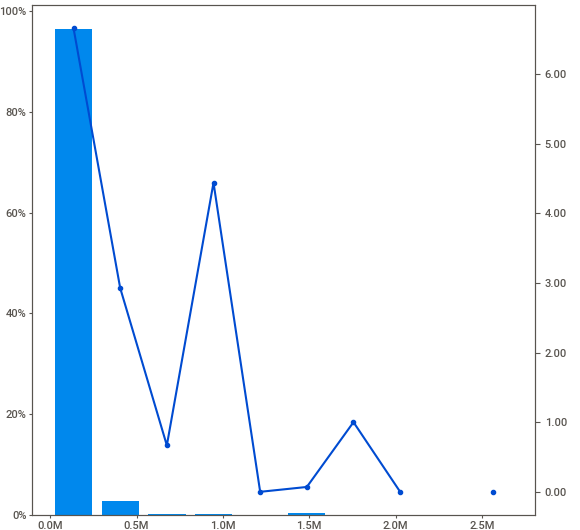
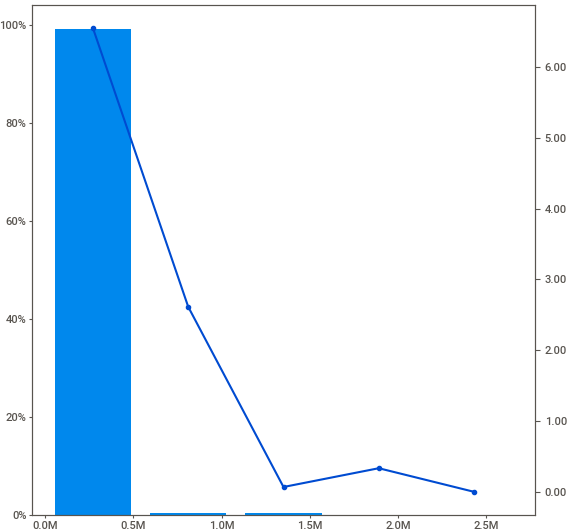
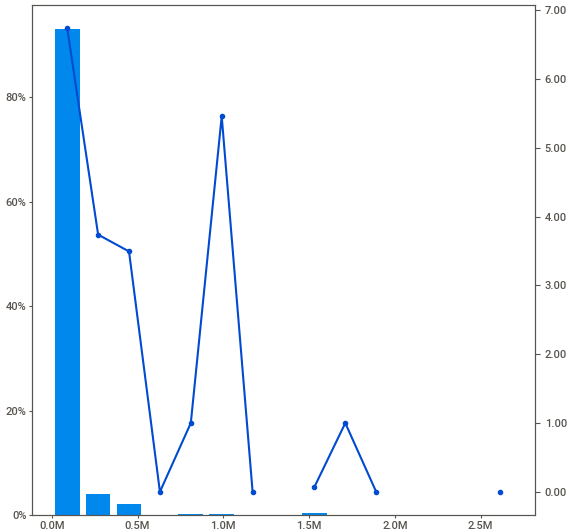
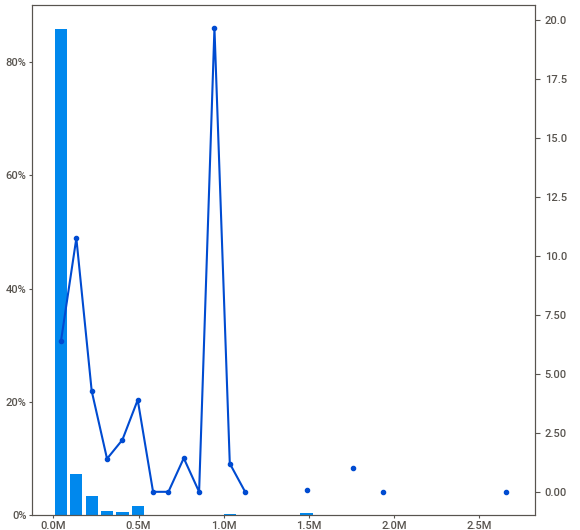
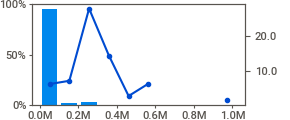
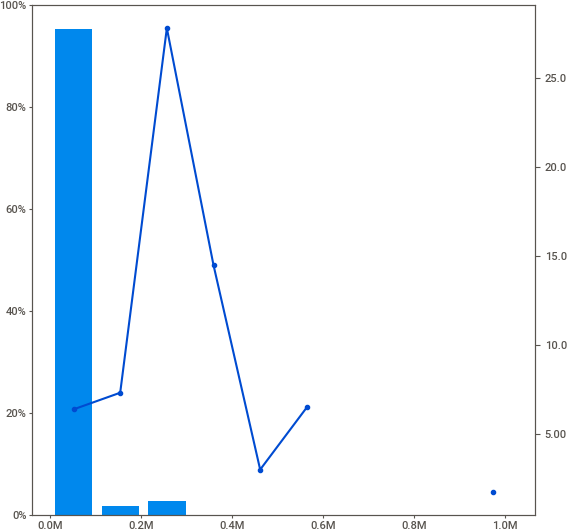
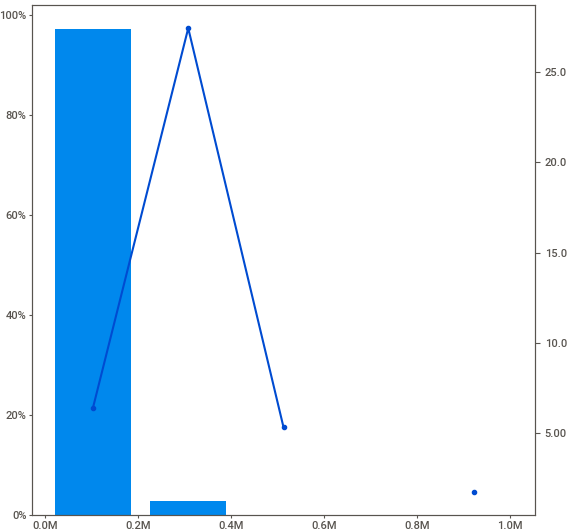
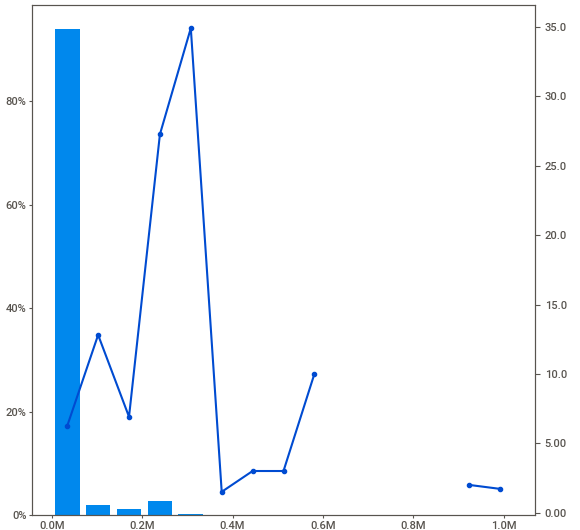
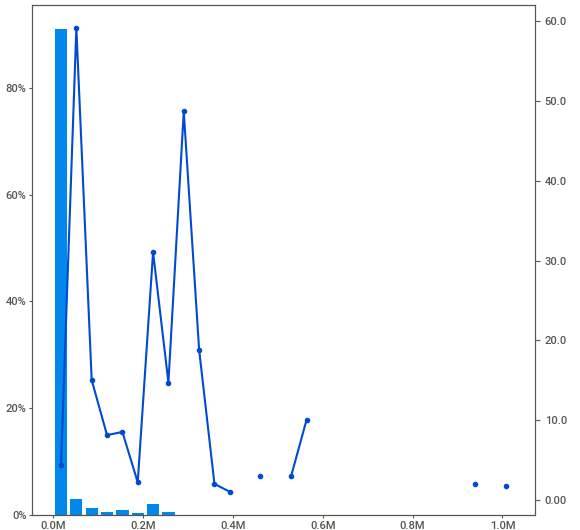
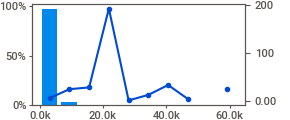
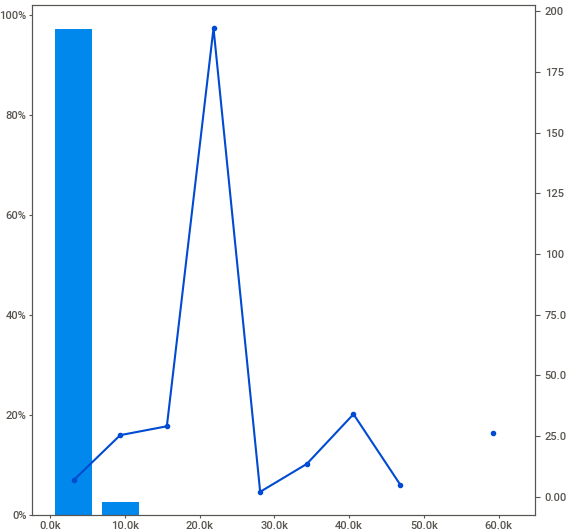
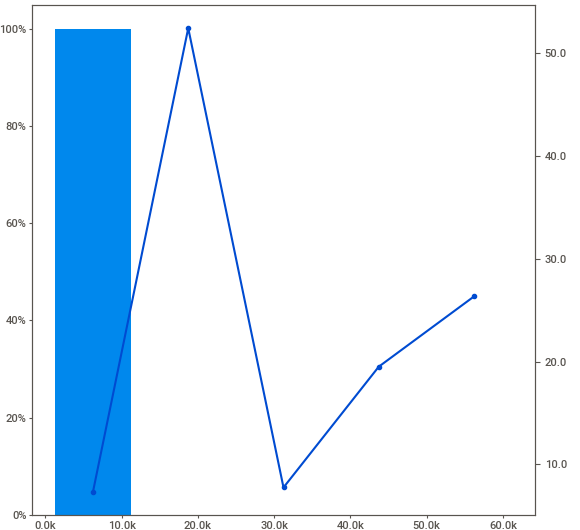
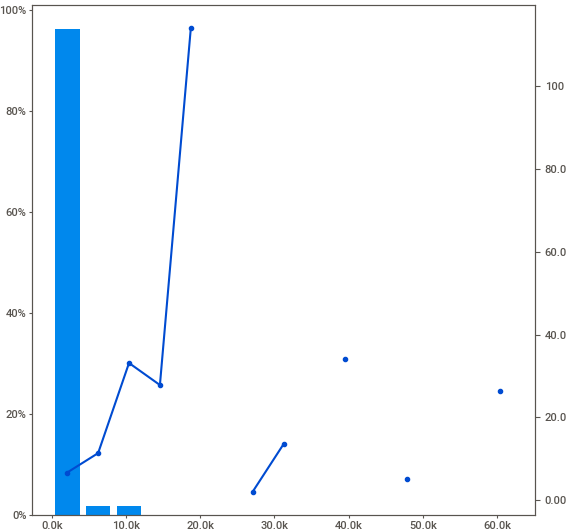
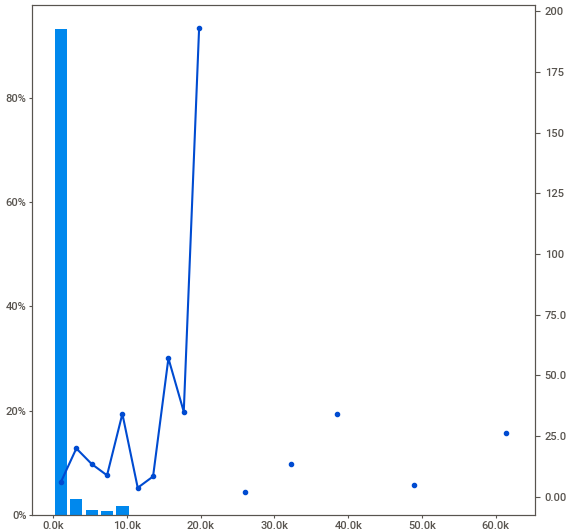
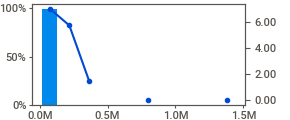
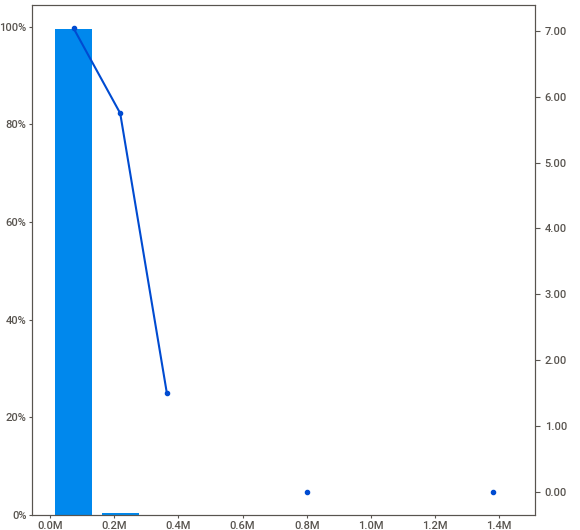
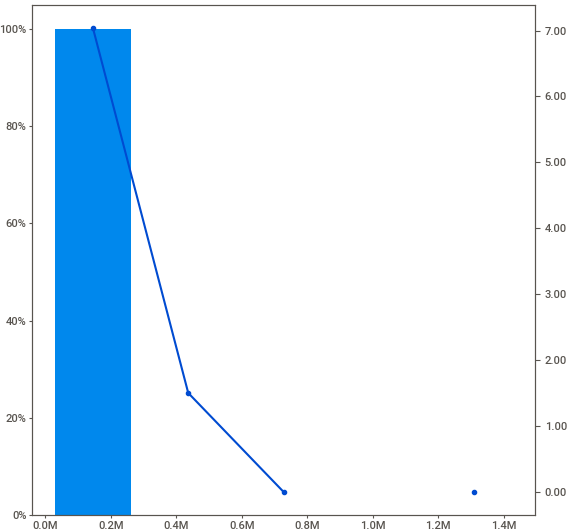
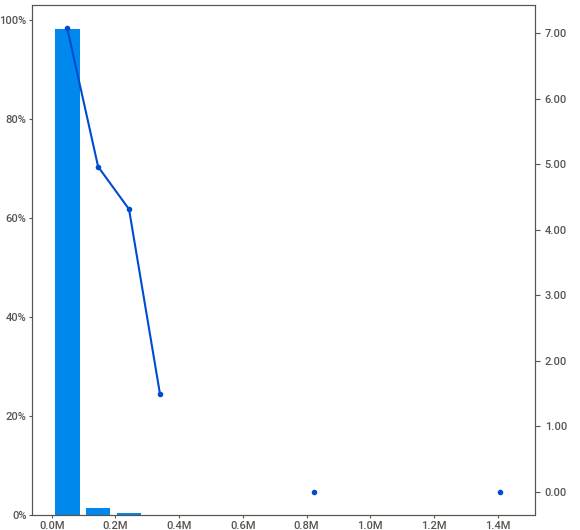
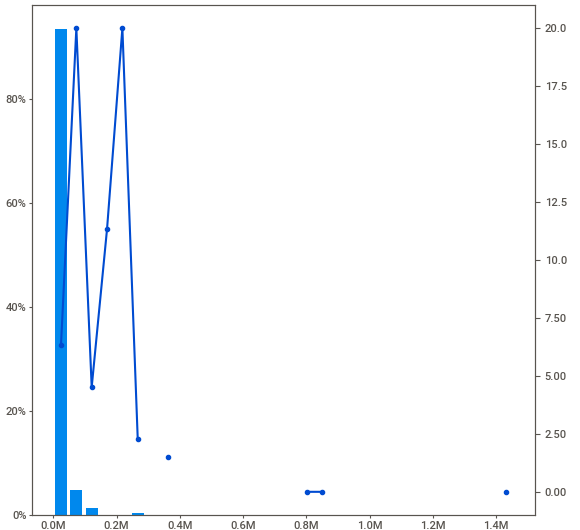
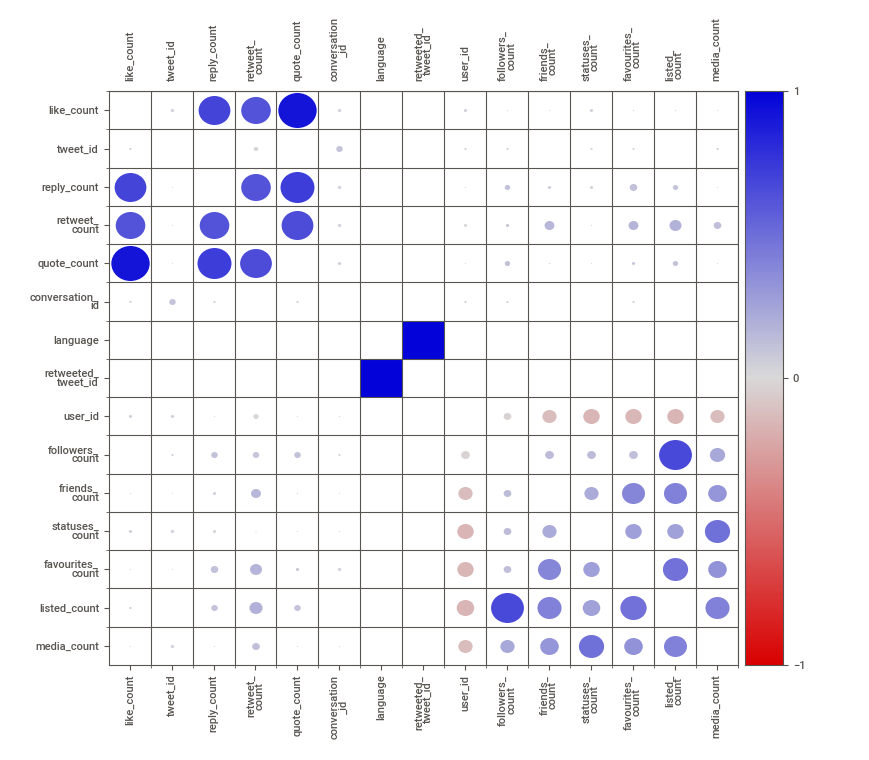
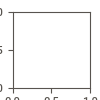

In [ ]:
display(HTML('Report.html'))

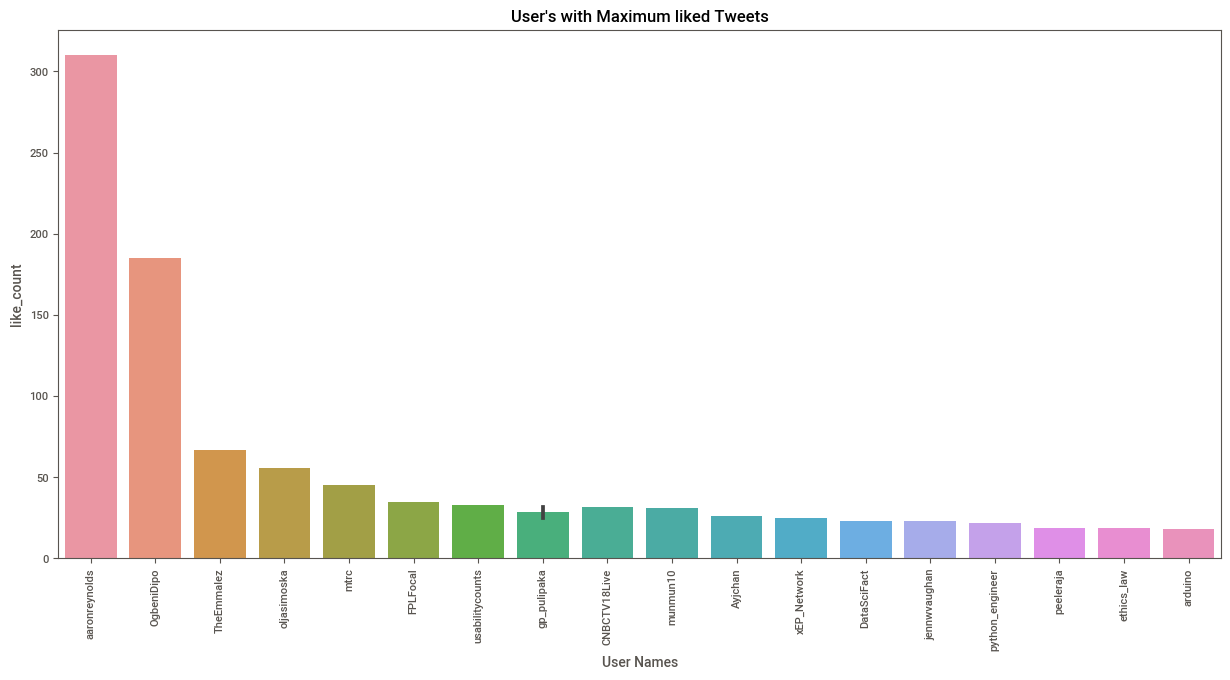

In [ ]:
# User's with Maximum liked Tweets
toprating_df = df.sort_values('like_count', ascending=False).head(20)

plt.figure(figsize=(15,7))
p = sns.barplot(x='username', y="like_count", data=toprating_df,)
p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 8)
p.set_title("User's with Maximum liked Tweets")
p.set(xlabel="User Names", ylabel="like_count")
plt.savefig("Users_with_max_liked_tweets.png", dpi=500)

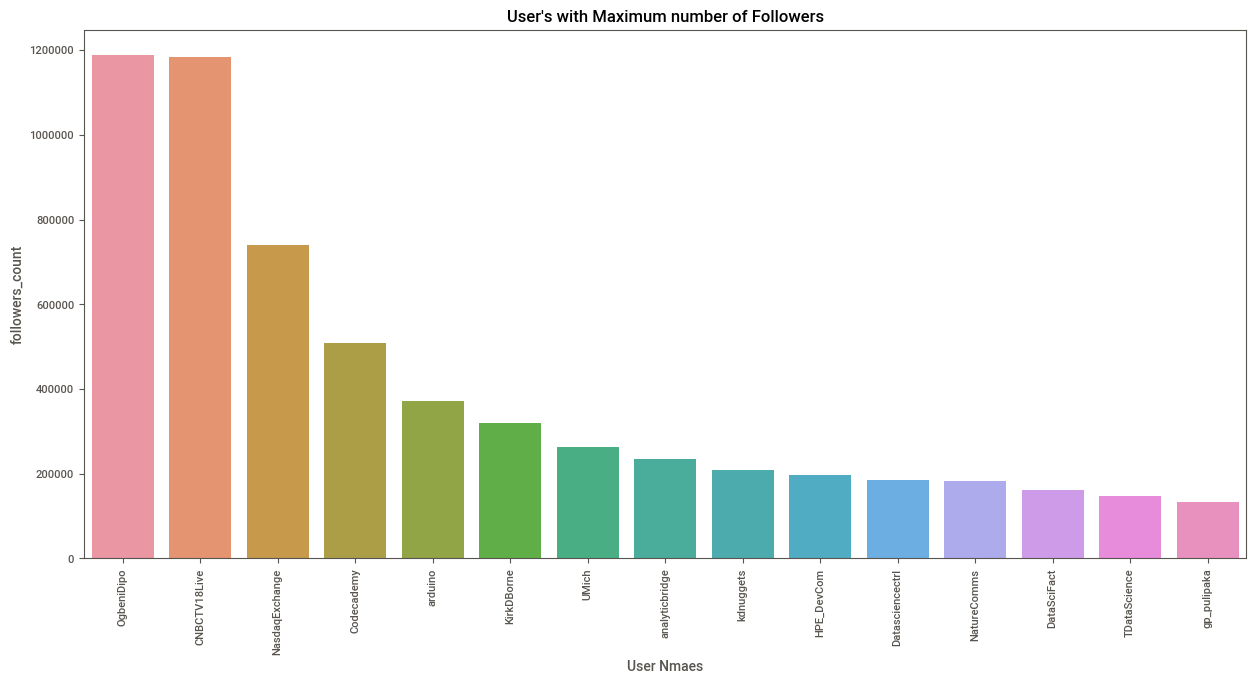

In [ ]:
# User's with Maximum followers
toprating_df = df.sort_values('followers_count', ascending=False).head(20)

plt.figure(figsize=(15,7))
p = sns.barplot(x='username', y="followers_count", data=toprating_df,)
p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 8)
p.set_title("User's with Maximum number of Followers")
p.set(xlabel="User Nmaes", ylabel="followers_count")
plt.savefig("Users_with_max_followers.png", dpi=500)

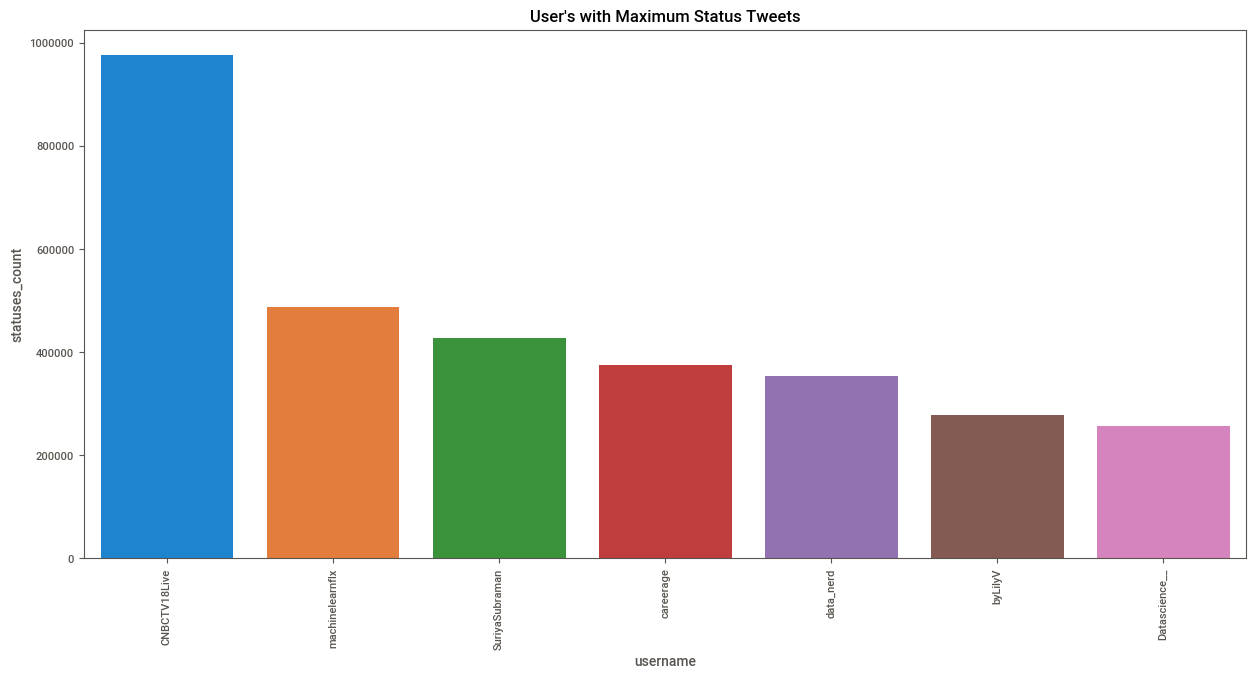

In [ ]:
# User's with Maximum Status Tweets
toprating_df = df.sort_values('statuses_count', ascending=False).head(20)

plt.figure(figsize=(15,7))
p = sns.barplot(x='username', y="statuses_count", data=toprating_df,)
p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 8)
p.set_title("User's with Maximum Status Tweets")
p.set(xlabel="username", ylabel="statuses_count")
plt.savefig("Users_with_max_status_tweets.png", dpi=500)

# Processing text in tweet

In [ ]:
# using sentence transformer with bert based model
model = SentenceTransformer('bert-base-nli-mean-tokens') 
vectorized_df = pd.DataFrame(model.encode(tweets_df['tweet_content'].tolist())) 

In [ ]:
vectorized_df = pd.concat([tweets_df, vectorized_df], axis=1) 
vectorized_df.inreply_to_tweet_id = vectorized_df.inreply_to_tweet_id.str.replace('None','0').astype(int)
tweets_vec_df = vectorized_df.drop(['url','tweet_date','tweet_content','tweet_id','conversation_id','language','retweeted_tweet_id','quoted_tweet_id',\
                    'inreply_to_tweet_id','user_id','username','displayname','description'],axis=1).fillna(0) 

# PCA

## Standardizing the data

In [ ]:
scaler = StandardScaler() 
tweet_std_df = scaler.fit_transform(tweets_vec_df) 
tweet_std_df = pd.DataFrame(tweet_std_df, columns = tweets_vec_df.columns) 

## Finding optimal no of components

In [ ]:
n_components = 100
principal = PCA(n_components=n_components) 
tweet_std_df = principal.fit_transform(tweet_std_df)  

n_comp_pca = np.arange(1,n_components+1,1) 
var_perc_pca = principal.explained_variance_ratio_ # get explained variances ratio
var_cmsm_pca = var_perc_pca.cumsum() # get cum_sum() of explained variances 

n_comp_opti = n_comp_pca[np.nonzero(var_cmsm_pca>0.8)][0]
var_cap_opti = var_cmsm_pca[n_comp_opti-1] 

80.19% variance is captured with 55 no of components



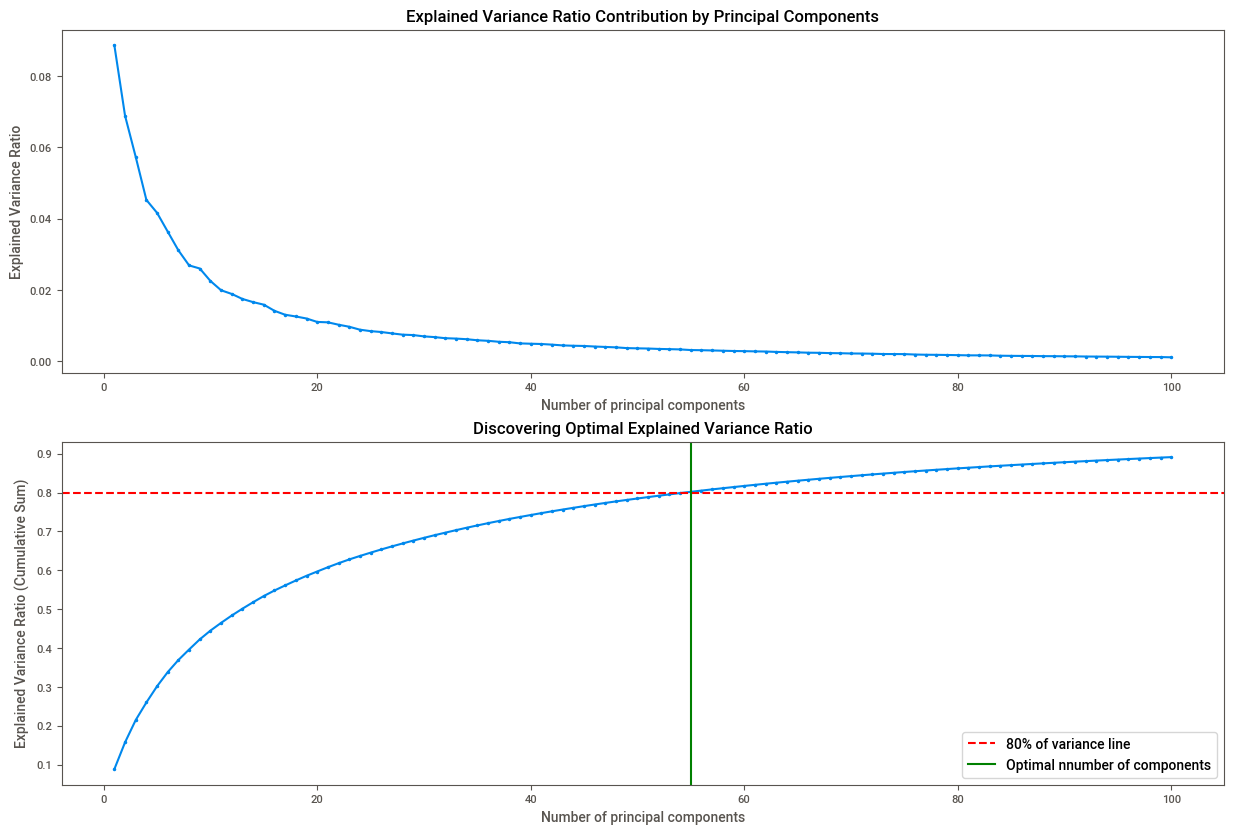

In [ ]:
# your code here 
# Plotting 2 subplots for explained variance ratio and cumulative sum of explained variance ratio 
fig, ax = plt.subplots(2, 1, figsize=(15,10))

ax[0].plot(n_comp_pca, var_perc_pca,marker='.')
ax[0].set_xlabel('Number of principal components')
ax[0].set_ylabel('Explained Variance Ratio')
ax[0].set_title('Explained Variance Ratio Contribution by Principal Components')


ax[1].plot(n_comp_pca, var_cmsm_pca,marker='.')
ax[1].axhline(0.8,linestyle='--',color='r',label='80% of variance line')
ax[1].set_xlabel('Number of principal components')
ax[1].set_ylabel('Explained Variance Ratio (Cumulative Sum)')
ax[1].set_title('Discovering Optimal Explained Variance Ratio')
ax[1].axvline(n_comp_opti,color='g',label='Optimal nnumber of components')
ax[1].legend()

print(f"{var_cap_opti*100:.2f}% variance is captured with {n_comp_opti} no of components\n")

plt.show()

## Final pca model

In [ ]:
n_components = n_comp_opti
principal = PCA(n_components=n_components) 
tweet_std_df = principal.fit_transform(tweet_std_df)  
tweet_std_pca_df = pd.DataFrame(tweet_std_df, columns=[f'y{i}' for i in range(1,n_components+1)]) 
tweet_std_pca_comp_df = pd.DataFrame(principal.components_, columns=[f'feature_{i}' for i in range(principal.components_.shape[1])]) 

In [ ]:
tweet_std_pca_df

y1         y2         y3        y4        y5         y6  \
0     12.602964   7.090812  -3.169262 -4.577069  0.132162   4.148124   
1     -8.261481   2.218106  -5.236197  5.502036 -4.177741   5.343655   
2      4.852888   8.403989  -0.806855  1.007504 -4.259279  -6.117318   
3      0.810948   6.843582  -1.030394  0.243804  4.144607  -3.873214   
4      0.702818  -7.189757   0.198513 -2.331923  5.080223  -0.030025   
...         ...        ...        ...       ...       ...        ...   
9995   7.463003 -10.306539   1.741950 -1.734121 -0.281719  -2.966970   
9996  -4.057248   6.395197  -8.000080 -6.415234  5.416373  -5.634495   
9997  -9.101109   2.536059   1.520237  9.965106 -0.457945   6.654547   
9998  -8.647281   3.002614  10.304865 -8.876622  0.206524   2.591995   
9999  -8.465513   4.389193  -7.392384  1.170698 -7.377894  16.327409   

             y7        y8        y9       y10  ...       y46       y47  \
0     12.560034 -5.089325  0.161522  1.775053  ... -0.343941  2.035634   
1      1.395834 -4.196042 -1.744714 -3.695878  ... -1.634831  1.544109   
2     -6.393007  1.914073  1.219268 -6.323309  ... -1.119308  0.960197   
3     -2.388395 -1.840119  4.416860 -4.908253  ...  1.829608 -0.560747   
4     -3.298971 -5.109235 -3.616772 -1.491018  ...  2.723239  0.250838   
...         ...       ...       ...       ...  ...       ...       ...   
9995   3.667835  4.148350 -1.239245 -1.401825  ... -2.640672  2.926116   
9996   0.647620  1.591422  1.877417  2.027532  ...  0.185807 -1.682026   
9997   1.747758  0.885717 -6.560994 -5.315240  ...  0.381925 -0.553613   
9998   0.547419 -0.249133 -1.463494  6.243604  ...  0.136793  0.819746   
9999   6.317400 -1.603789  5.281070  4.455950  ...  0.646080  0.859849   

           y48       y49       y50       y51       y52       y53       y54  \
0    -0.044098 -0.286780 -0.561132  1.114819  2.410319  1.068586 -3.520274   
1     0.963025  0.312776 -1.188092 -1.294301  0.822556 -2.698477  1.481347   
2    -0.499599 -3.311748  1.247749  0.258669 -0.313439  3.078422 -0.245677   
3    -0.078767 -0.117919  0.246076 -0.705881  0.947277 -1.948860  0.101252   
4    -0.989173  0.162026 -2.347350 -2.871879  2.381892  1.031435  0.694999   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -1.529781  0.085557 -1.486164 -0.360970 -1.416740  1.312467  2.577382   
9996 -1.114531  0.191953  3.326041 -0.836195 -1.469736 -1.727190  1.417200   
9997  0.812671  1.032466 -1.125232 -1.319935 -2.674306  1.408752 -1.651392   
9998  3.632853  2.763921  0.142275 -1.628600 -0.157762  2.786235 -1.409366   
9999 -1.105010  2.281392 -0.855831  0.622569  0.188630 -2.219941 -1.596124   

           y55  
0     2.317181  
1    -0.825343  
2     3.886358  
3    -1.573882  
4     0.025938  
...        ...  
9995  1.931763  
9996 -0.174371  
9997 -1.251103  
9998 -3.114984  
9999 -0.504706  

[10000 rows x 55 columns]

<Figure size 1500x1000 with 0 Axes>

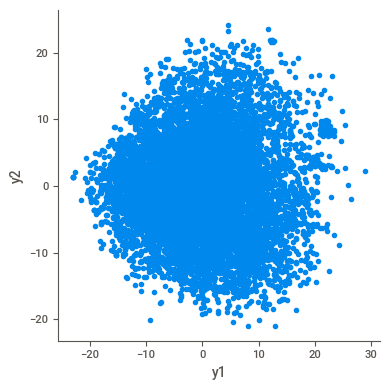

In [ ]:
plt.figure(figsize=(15,10))
sns.FacetGrid(tweet_std_pca_df,height=4,aspect=1).map(plt.scatter, 'y1', 'y2')
plt.show() 

<Figure size 1500x1000 with 0 Axes>

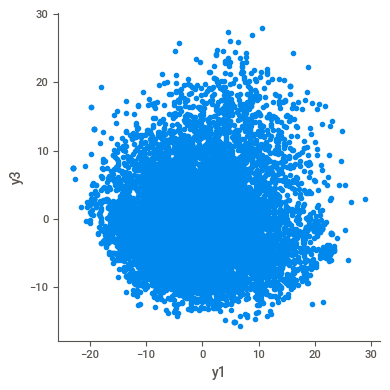

In [ ]:
plt.figure(figsize=(15,10))
sns.FacetGrid(tweet_std_pca_df,height=4,aspect=1).map(plt.scatter, 'y1', 'y3')
plt.show() 

# t-SNE

## Fitting t-SNE on with n_components=3

In [ ]:
model = TSNE(n_components=3, random_state=0) 
tsne_data = model.fit_transform(tweets_vec_df)  
tsne_data = pd.DataFrame(tsne_data,columns=[f'y{i}' for i in range(1,4)])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


## Plotting the distributions in principal components

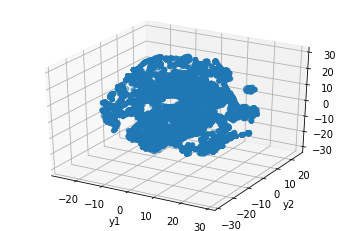

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

X = tsne_data.values
ax.scatter(xs=X[:,0].squeeze(), ys=X[:,1].squeeze(),zs=X[:,2].squeeze()) 
ax.set_xlabel('y1') 
ax.set_ylabel('y2') 

plt.show() 

<Figure size 1080x720 with 0 Axes>

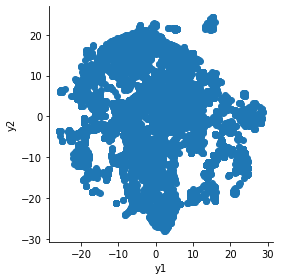

In [ ]:
plt.figure(figsize=(15,10)) 
sns.FacetGrid(tsne_data,height=4,aspect=1).map(plt.scatter, 'y1', 'y2')
plt.show() 

<Figure size 1080x720 with 0 Axes>

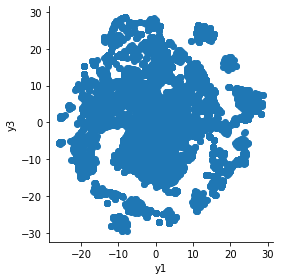

In [ ]:
plt.figure(figsize=(15,10)) 
sns.FacetGrid(tsne_data,height=4,aspect=1).map(plt.scatter, 'y1', 'y3')
plt.show() 

<Figure size 1080x720 with 0 Axes>

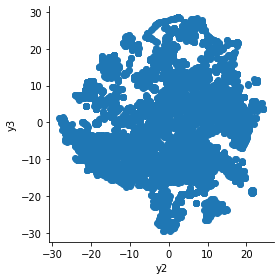

In [ ]:
plt.figure(figsize=(15,10)) 
sns.FacetGrid(tsne_data,height=4,aspect=1).map(plt.scatter, 'y2', 'y3')
plt.show() 

# Clustering

## KMeans

In [ ]:
X = tweet_std_pca_df.values
inertias = {}
centers_list = []
niter = 10

for i in range(1,niter+1):
  kmeans = KMeans(n_clusters=i, random_state=0)
  y_pred = kmeans.fit_predict(X)
  n_centers = kmeans.cluster_centers_
  centers_list.append(n_centers)
  inertias[i] = kmeans.inertia_


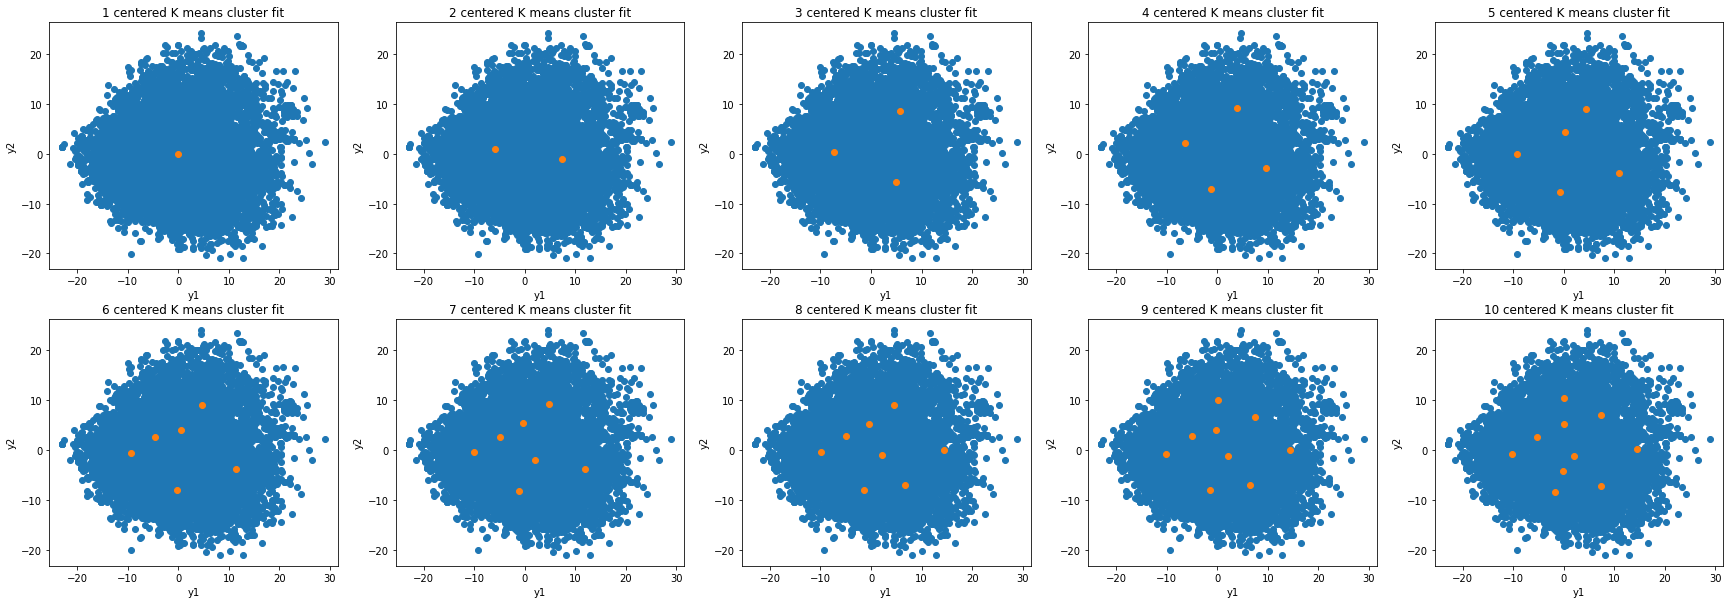

In [ ]:
# Plotting 10 subplots for all 10 values of k
fig, ax = plt.subplots(2,5, figsize=(30,10))
ax = ax.ravel() 

for i in range(niter):
  ax[i].set_title(f'{i+1} centered K means cluster fit')
  ax[i].scatter(X[:,0], X[:,1])
  ax[i].scatter(centers_list[i][:,0], centers_list[i][:,1])
  ax[i].set_xlabel('y1')
  ax[i].set_ylabel('y2')

plt.show()

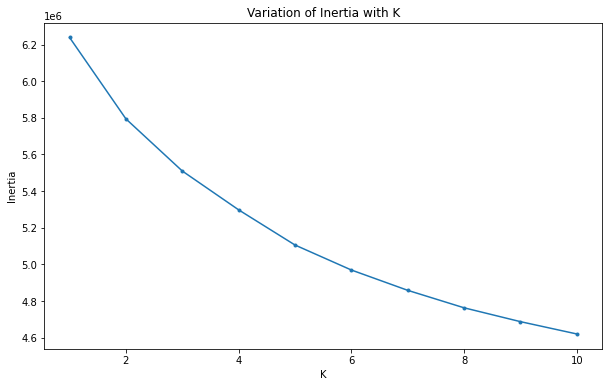

In [ ]:
# your code here 
# Plotting inertia vs k
plt.figure(figsize=(10,6))

plt.plot(list(inertias.keys()), list(inertias.values()),marker='.')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Variation of Inertia with K')

plt.show()

## DBSCAN

### Optimal eps

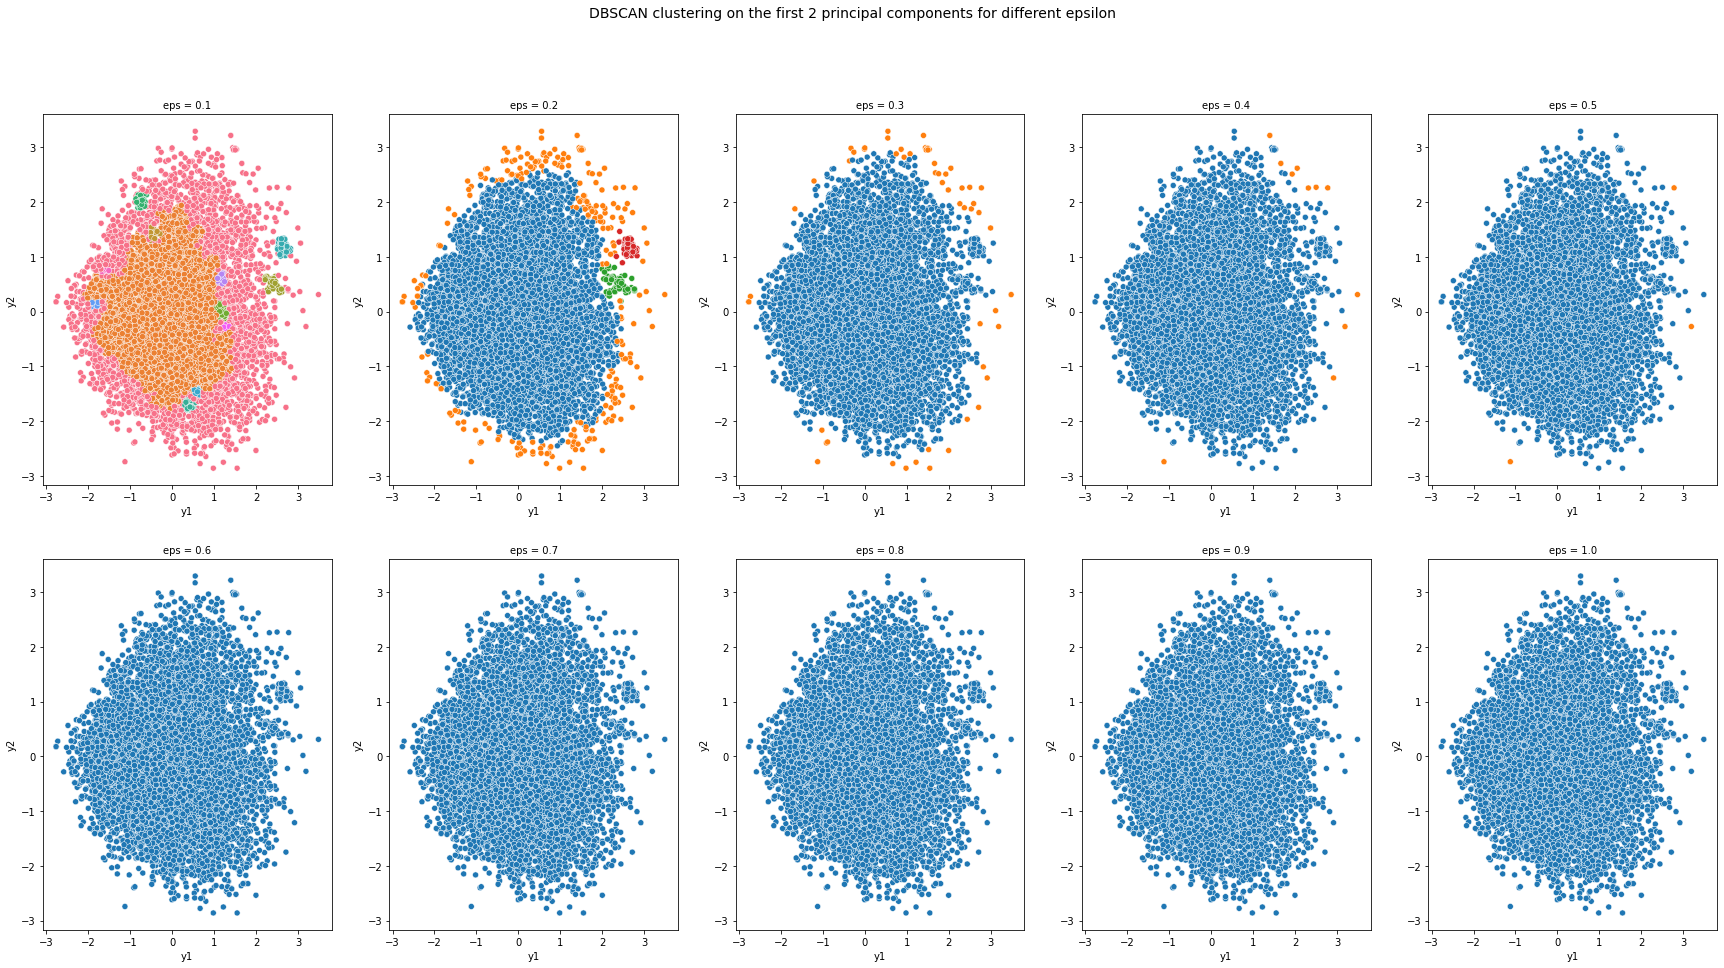

In [ ]:
# your code here 
# Plot 10 subplots for all 10 values of epsilon 
X = StandardScaler().fit_transform(tweets_vec_df.values)
min_samples = 20 

fig = plt.figure(figsize=(30,15)) 
i = 1 
epss = np.linspace(0.1,1,10) 
for eps in epss:
  db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
  labels = db.labels_
  
  ax = fig.add_subplot(2, 5, i) 
  ax.set_title("eps = {}".format(round(eps, 2)), fontsize=10)
  sns.scatterplot(x=X[:,0], y=X[:,1], hue=["cluster-{}".format(x) for x in labels], legend = False)
  ax.set_xlabel('y1')
  ax.set_ylabel('y2')
  i += 1 

fig.suptitle("DBSCAN clustering on the first 2 principal components for different epsilon", fontsize=14)
plt.show() 

In [ ]:
# your code here 
nearest_neighbors = 20 
neighbors = NearestNeighbors(n_neighbors=nearest_neighbors).fit(X) 
distances, indices = neighbors.kneighbors(X, nearest_neighbors)
distances = np.sort(distances[:,19], axis=0) 

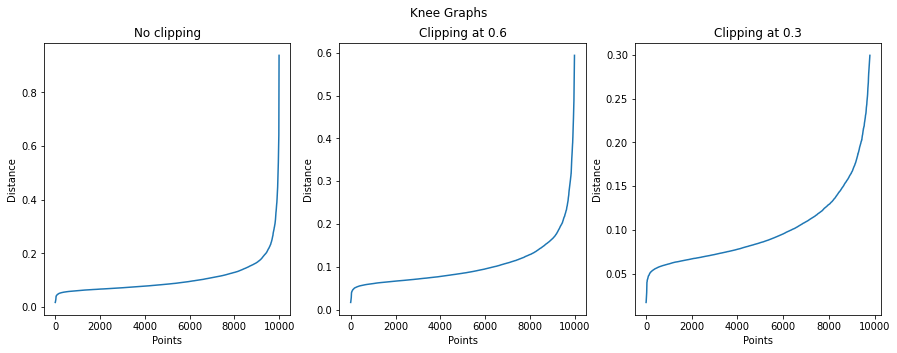

In [ ]:
#Plotting the entire distances array
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax = ax.ravel()

ax[0].plot(distances)
ax[0].set_xlabel("Points") 
ax[0].set_ylabel("Distance")
ax[0].set_title('No clipping')

ax[1].plot(distances[np.nonzero(distances[distances<0.6])[0]])
ax[1].set_xlabel("Points") 
ax[1].set_ylabel("Distance")
ax[1].set_title('Clipping at 0.6')

ax[2].plot(distances[np.nonzero(distances[distances<0.3])[0]])
ax[2].set_xlabel("Points") 
ax[2].set_ylabel("Distance")
ax[2].set_title('Clipping at 0.3')

fig.suptitle("Knee Graphs")
plt.show()

In [ ]:
eps_opti = 0.2 

### Optimal min_samples

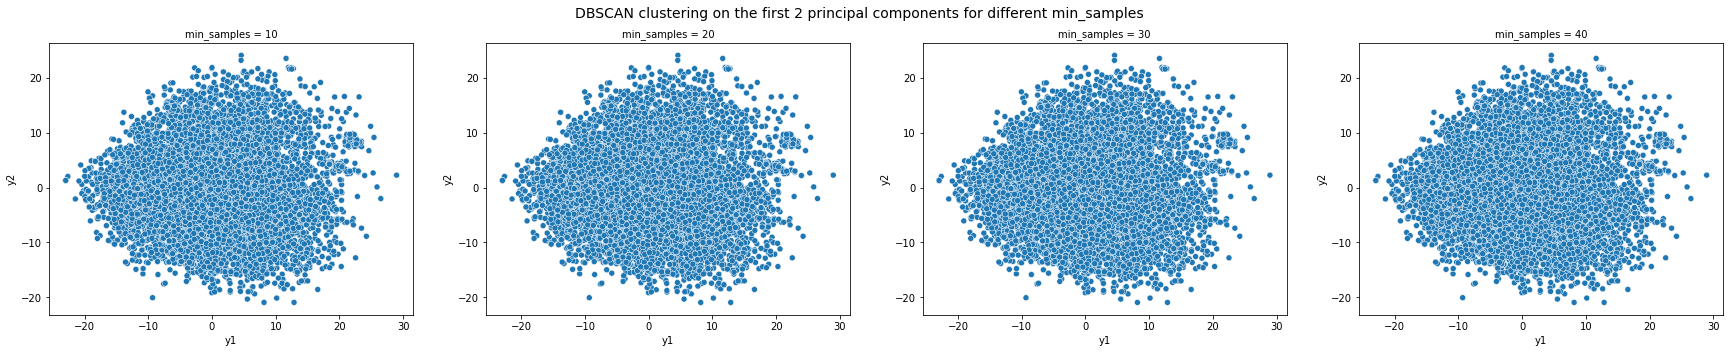

In [ ]:
# your code here
fig = plt.figure(figsize=(30,5))
p = 1 
for min_s in [10,20,30,40]:
  db = DBSCAN(eps=eps_opti, min_samples=min_s).fit(X)
  labels = db.labels_

  ax = fig.add_subplot(1, 4, p)
  ax.set_title("min_samples = {}".format(min_s), fontsize=10)
  sns.scatterplot(x=X[:,0], y=X[:,1], hue=["cluster-{}".format(x) for x in labels],legend=False)
  ax.set_xlabel('y1')
  ax.set_ylabel('y2')
  p += 1

fig.suptitle("DBSCAN clustering on the first 2 principal components for different min_samples", fontsize=14)
plt.show() 

# Recommendation System

In [ ]:
scores = [0] * len(vectorized_df)

twt_no = 0
content = user_df.iloc[twt_no]['content']
pred = tweets_vec_df.values
for j in range(len(vectorized_df)):
  row = list(vectorized_df.iloc[j])[-len(pred):]
  scores[j] += (1 - spatial.distance.cosine(pred, row))

for indx, score in enumerate(scores):
  scores[indx] = score / len(user_df) 

vectorized_df['scores'] = pd.Series(scores)
vectorized_df = vectorized_df.sort_values('scores', ascending=False)
vectorized_df = vectorized_df.reset_index(drop=True)
del scores

# Conclusion & Results

1. The final recommender displays tweets based on cosine similarity. This has led to a few tweets which match on a few keywords only to sneak into the feed. 
2. The user tweet based analytics displays more popular tweets that match the user's tweet. Few tweets that are extremely popular manage to rank up and move into the top 10 displayed tweets.
3. Using BERT based model for tokenization of sentences yielded better results compared to bare tf-idf vectorizer.
4. The final model was integrated into a pipeline and deployed on Heroku.


# Future Scope

1. The topic vector can be improved with by choosing better language models and better queries can be formulated using context based keyword mapping.
2. A feedback mechanism can be built on top of the current interface for the user to report bad tweets and upvote useful tweets.
3. The popularity potential of a tweet can be predicted using user followers, performance of similar tweets in the past and additional factors.
